# 1.Multigpu Distributed Training-ScriptMode
---

본 모듈에서는 Amzaon SageMaker API을 효과적으로 이용하기 위해 multigpu-distributed 학습을 위한 PyTorch 프레임워크 자체 구현만으로 모델 훈련을 수행해 봅니다.

## 1. Sagemaker notebook 설명
<p>Sagemaker notebook은 완전 관리형 서비스로 컨테이너 기반으로 구성되어 있습니다. 사용자가 직접 컨테이너를 볼 수 없지만, 내부적으로는 아래와 같은 원리로 동작합니다. </p>
<p><img src="./imgs/fig00.png" width="800", height="80"></p>

- **S3 (Simple Storage Serivce)** : Object Storage로서 학습할 데이터 파일과 학습 결과인 model, checkpoint, tensorboard를 위한 event 파일, 로그 정보 등을 저장하는데 사용합니다.
- **SageMaker Notebook** : 학습을 위한 스크립트 작성과 디버깅, 그리고 실제 학습을 수행하기 위한 Python을 개발하기 위한 환경을 제공합니다.
- **Amazon Elastic Container Registry(ECR)** :  Docker 컨테이너 이미지를 손쉽게 저장, 관리 및 배포할 수 있게 해주는 완전관리형 Docker 컨테이너 레지스트리입니다. Sagemaker는 기본적인 컨테이너를 제공하기 때문에 별도 ECR에 컨테이너 이미지를 등록할 필요는 없습니다. 하지만, 별도의 학습 및 배포 환경이 필요한 경우 custom 컨테이너 이미지를 만들어서 ECR에 등록한 후 이 환경을 활용할 수 있습니다.

<p>학습과 추론을 하는 hosting 서비스는 각각 다른 컨테이너 환경에서 수행할 수 있으며, 쉽게 다량으로 컨테이너 환경을 확장할 수 있으므로 다량의 학습과 hosting이 동시에 가능합니다.   
</p>

In [1]:
import sys

In [2]:
!{sys.executable} -m pip install split-folders tqdm
# !{sys.executable} -m pip install 'sagemaker[local]' --upgrade

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


## 2. 환경 설정

<p>Sagemaker 학습에 필요한 기본적인 package를 import 합니다. </p>
<p>boto3는 HTTP API 호출을 숨기는 편한 추상화 모델을 가지고 있고, Amazon EC2 인스턴스 및 S3 버켓과 같은 AWS 리소스와 동작하는 파이선 클래스를 제공합니다. </p>
<p>sagemaker python sdk는 Amazon SageMaker에서 기계 학습 모델을 교육 및 배포하기 위한 오픈 소스 라이브러리입니다.</p>

In [3]:
import joblib
import matplotlib.pyplot as plt
import sagemaker
import splitfolders

import datetime
import glob
import os
import time
import warnings

import boto3
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision

from PIL import Image
from torch.utils.data import Dataset
from torchvision import datasets, transforms

from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorch

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [4]:
sess = boto3.Session()
sagemaker_session = sagemaker.Session()
sm = sess.client('sagemaker')
role = get_execution_role()

## 3. S3의 저장 데이터 위치 가져오기
<p> 데이터를 정하기 위한 S3의 bucket 위치는 아래 data_bucket 이름으로 생성하며, 기본적으로 SageMaker에서 학습한 모델과 로그 정보를 남기는 위치는 자동으로 생성되는 bucket 이름으로 저장됩니다. </p>

In [5]:
# create a s3 bucket to hold data, note that your account might already created a bucket with the same name
account_id = sess.client('sts').get_caller_identity()["Account"]
job_bucket = 'sagemaker-experiments-{}-{}'.format(sess.region_name, account_id)
data_bucket = 'sagemaker-{}-{}'.format(sess.region_name, account_id)
try:
    if sess.region_name == "us-east-1":
        sess.client('s3').create_bucket(Bucket=data_bucket)
    else:
        sess.client('s3').create_bucket(Bucket=data_bucket, 
                                        CreateBucketConfiguration={'LocationConstraint': sess.region_name})
except Exception as e:
    print(e)

## 4. Dataset 소개 및 split 후 S3 upload하기
<p>이번 학습에 사용할 이미지 데이터는 <strong><a href="https://www.robots.ox.ac.uk/~vgg/data/pets/" target="_blank" class ='btn-default'>Oxford-IIIT Pet Dataset</a></strong> 입니다. Oxford-IIIT Pet Dataset은 <strong>37</strong>개 다른 종의 개와 고양이 이미지를 각각 200장 씩 제공하고 있으며, Ground Truth 또한 Classification, Object Detection, Segmentation와 관련된 모든 정보가 있으나, 이번 학습에서는 37개 class에 대해 일부 이미지로 Classification 문제를 해결하기 위해 학습을 진행할 예정입니다.</p>
<p><img src="./imgs/pet_annotations.jpg" width="700", height="70"></p>    
<p>이미지 파일을 학습하기 위해 SageMaker Notebook 환경으로 upload를 합니다. 폴더 구조는 아래와 같은 형태로 구성되어야 합니다. </p>
<pre>
<div style='line-height:80%'>
    image_path/class1/Aimage_1<br>
                      Aimage_2<br>
                       ...<br>
                      Aimage_N<br>
    image_path/class2/Bimage_1<br>
                      Bimage_2<br>
                       ...<br>
                      Bimage_M<br>
</div>
</pre>

<p>SageMaker 학습을 위해 train/val로 분리한 폴더를 S3내 이전에 지정한 data_bucket 내 prefix 하위 폴더로 upload합니다. </p>

In [6]:
!cat ./raw_img/data.tar.gz* | tar -zxvpf -

data/
data/Ragdoll/
data/Ragdoll/Ragdoll_171.jpg
data/Ragdoll/Ragdoll_78.jpg
data/Ragdoll/Ragdoll_163.jpg
data/Ragdoll/Ragdoll_257.jpg
data/Ragdoll/Ragdoll_43.jpg
data/Ragdoll/Ragdoll_254.jpg
data/Ragdoll/Ragdoll_193.jpg
data/Ragdoll/Ragdoll_4.jpg
data/Ragdoll/Ragdoll_175.jpg
data/Ragdoll/Ragdoll_18.jpg
data/Ragdoll/Ragdoll_199.jpg
data/Ragdoll/Ragdoll_104.jpg
data/Ragdoll/Ragdoll_37.jpg
data/Ragdoll/Ragdoll_3.jpg
data/Ragdoll/Ragdoll_75.jpg
data/Ragdoll/Ragdoll_96.jpg
data/Ragdoll/Ragdoll_44.jpg
data/Ragdoll/Ragdoll_80.jpg
data/Ragdoll/Ragdoll_137.jpg
data/Ragdoll/Ragdoll_90.jpg
data/Ragdoll/Ragdoll_100.jpg
data/Ragdoll/Ragdoll_25.jpg
data/Ragdoll/Ragdoll_135.jpg
data/Ragdoll/Ragdoll_210.jpg
data/Ragdoll/Ragdoll_98.jpg
data/Ragdoll/Ragdoll_180.jpg
data/Ragdoll/Ragdoll_74.jpg
data/Ragdoll/Ragdoll_161.jpg
data/Ragdoll/Ragdoll_185.jpg
data/Ragdoll/Ragdoll_255.jpg
data/Ragdoll/Ragdoll_62.jpg
data/Ragdoll/Ragdoll_68.jpg
data/Ragdoll/Ragdoll_179.jpg
data/Ragdoll/Ragdoll_121.jpg
data/Ragdoll

data/japanese_chin/japanese_chin_20.jpg
data/japanese_chin/japanese_chin_1.jpg
data/japanese_chin/japanese_chin_178.jpg
data/japanese_chin/japanese_chin_141.jpg
data/japanese_chin/japanese_chin_126.jpg
data/japanese_chin/japanese_chin_14.jpg
data/japanese_chin/japanese_chin_66.jpg
data/japanese_chin/japanese_chin_118.jpg
data/japanese_chin/japanese_chin_40.jpg
data/japanese_chin/japanese_chin_84.jpg
data/japanese_chin/japanese_chin_81.jpg
data/japanese_chin/japanese_chin_73.jpg
data/japanese_chin/japanese_chin_95.jpg
data/japanese_chin/japanese_chin_51.jpg
data/japanese_chin/japanese_chin_117.jpg
data/japanese_chin/japanese_chin_92.jpg
data/japanese_chin/japanese_chin_124.jpg
data/japanese_chin/japanese_chin_71.jpg
data/japanese_chin/japanese_chin_169.jpg
data/japanese_chin/japanese_chin_18.jpg
data/japanese_chin/japanese_chin_199.jpg
data/japanese_chin/japanese_chin_113.jpg
data/japanese_chin/japanese_chin_47.jpg
data/japanese_chin/japanese_chin_86.jpg
data/japanese_chin/japanese_chin

data/boxer/boxer_98.jpg
data/boxer/boxer_63.jpg
data/boxer/boxer_131.jpg
data/boxer/boxer_7.jpg
data/boxer/boxer_72.jpg
data/boxer/boxer_122.jpg
data/boxer/boxer_189.jpg
data/boxer/boxer_183.jpg
data/boxer/boxer_165.jpg
data/boxer/boxer_127.jpg
data/boxer/boxer_104.jpg
data/samoyed/
data/samoyed/samoyed_185.jpg
data/samoyed/samoyed_82.jpg
data/samoyed/samoyed_36.jpg
data/samoyed/samoyed_47.jpg
data/samoyed/samoyed_160.jpg
data/samoyed/samoyed_83.jpg
data/samoyed/samoyed_68.jpg
data/samoyed/samoyed_85.jpg
data/samoyed/samoyed_61.jpg
data/samoyed/samoyed_26.jpg
data/samoyed/samoyed_54.jpg
data/samoyed/samoyed_104.jpg
data/samoyed/samoyed_18.jpg
data/samoyed/samoyed_15.jpg
data/samoyed/samoyed_125.jpg
data/samoyed/samoyed_143.jpg
data/samoyed/samoyed_69.jpg
data/samoyed/samoyed_5.jpg
data/samoyed/samoyed_30.jpg
data/samoyed/samoyed_136.jpg
data/samoyed/samoyed_38.jpg
data/samoyed/samoyed_177.jpg
data/samoyed/samoyed_128.jpg
data/samoyed/samoyed_86.jpg
data/samoyed/samoyed_197.jpg
data/sam

data/Persian/Persian_195.jpg
data/Persian/Persian_71.jpg
data/Persian/Persian_239.jpg
data/Persian/Persian_14.jpg
data/Persian/Persian_185.jpg
data/Persian/Persian_200.jpg
data/Persian/Persian_217.jpg
data/Persian/Persian_213.jpg
data/Persian/Persian_45.jpg
data/Persian/Persian_103.jpg
data/Persian/Persian_128.jpg
data/Persian/Persian_137.jpg
data/Persian/Persian_31.jpg
data/Persian/Persian_84.jpg
data/Persian/Persian_170.jpg
data/Persian/Persian_161.jpg
data/Persian/Persian_191.jpg
data/Persian/Persian_40.jpg
data/Persian/Persian_255.jpg
data/Persian/Persian_51.jpg
data/Persian/Persian_132.jpg
data/Persian/Persian_107.jpg
data/Persian/Persian_77.jpg
data/Persian/Persian_8.jpg
data/Persian/Persian_49.jpg
data/Persian/Persian_44.jpg
data/Persian/Persian_180.jpg
data/Persian/Persian_88.jpg
data/Persian/Persian_9.jpg
data/Persian/Persian_121.jpg
data/Persian/Persian_181.jpg
data/Persian/Persian_6.jpg
data/Persian/Persian_4.jpg
data/Persian/Persian_52.jpg
data/Persian/Persian_270.jpg
data/

data/Birman/
data/Birman/Birman_57.jpg
data/Birman/Birman_174.jpg
data/Birman/Birman_91.jpg
data/Birman/Birman_97.jpg
data/Birman/Birman_177.jpg
data/Birman/Birman_107.jpg
data/Birman/Birman_24.jpg
data/Birman/Birman_172.jpg
data/Birman/Birman_7.jpg
data/Birman/Birman_80.jpg
data/Birman/Birman_94.jpg
data/Birman/Birman_200.jpg
data/Birman/Birman_102.jpg
data/Birman/Birman_33.jpg
data/Birman/Birman_122.jpg
data/Birman/Birman_98.jpg
data/Birman/Birman_44.jpg
data/Birman/Birman_25.jpg
data/Birman/Birman_87.jpg
data/Birman/Birman_30.jpg
data/Birman/Birman_61.jpg
data/Birman/Birman_143.jpg
data/Birman/Birman_114.jpg
data/Birman/Birman_103.jpg
data/Birman/Birman_187.jpg
data/Birman/Birman_22.jpg
data/Birman/Birman_132.jpg
data/Birman/Birman_115.jpg
data/Birman/Birman_167.jpg
data/Birman/Birman_150.jpg
data/Birman/Birman_34.jpg
data/Birman/Birman_38.jpg
data/Birman/Birman_73.jpg
data/Birman/Birman_145.jpg
data/Birman/Birman_45.jpg
data/Birman/Birman_123.jpg
data/Birman/Birman_152.jpg
data/Bir

data/saint_bernard/saint_bernard_53.jpg
data/saint_bernard/saint_bernard_132.jpg
data/saint_bernard/saint_bernard_82.jpg
data/saint_bernard/saint_bernard_199.jpg
data/saint_bernard/saint_bernard_85.jpg
data/saint_bernard/saint_bernard_89.jpg
data/saint_bernard/saint_bernard_52.jpg
data/saint_bernard/saint_bernard_188.jpg
data/saint_bernard/saint_bernard_117.jpg
data/saint_bernard/saint_bernard_113.jpg
data/saint_bernard/saint_bernard_193.jpg
data/saint_bernard/saint_bernard_125.jpg
data/saint_bernard/saint_bernard_28.jpg
data/saint_bernard/saint_bernard_81.jpg
data/saint_bernard/saint_bernard_167.jpg
data/saint_bernard/saint_bernard_31.jpg
data/saint_bernard/saint_bernard_34.jpg
data/saint_bernard/saint_bernard_9.jpg
data/saint_bernard/saint_bernard_155.jpg
data/saint_bernard/saint_bernard_163.jpg
data/saint_bernard/saint_bernard_101.jpg
data/saint_bernard/saint_bernard_62.jpg
data/saint_bernard/saint_bernard_25.jpg
data/saint_bernard/saint_bernard_153.jpg
data/saint_bernard/saint_bern

data/shiba_inu/shiba_inu_8.jpg
data/shiba_inu/shiba_inu_11.jpg
data/shiba_inu/shiba_inu_62.jpg
data/shiba_inu/shiba_inu_27.jpg
data/shiba_inu/shiba_inu_158.jpg
data/shiba_inu/shiba_inu_203.jpg
data/shiba_inu/shiba_inu_31.jpg
data/shiba_inu/shiba_inu_191.jpg
data/shiba_inu/shiba_inu_42.jpg
data/shiba_inu/shiba_inu_143.jpg
data/shiba_inu/shiba_inu_84.jpg
data/shiba_inu/shiba_inu_75.jpg
data/shiba_inu/shiba_inu_108.jpg
data/shiba_inu/shiba_inu_132.jpg
data/shiba_inu/shiba_inu_141.jpg
data/shiba_inu/shiba_inu_80.jpg
data/shiba_inu/shiba_inu_209.jpg
data/shiba_inu/shiba_inu_71.jpg
data/shiba_inu/shiba_inu_43.jpg
data/shiba_inu/shiba_inu_10.jpg
data/shiba_inu/shiba_inu_26.jpg
data/shiba_inu/shiba_inu_23.jpg
data/shiba_inu/shiba_inu_116.jpg
data/shiba_inu/shiba_inu_28.jpg
data/shiba_inu/shiba_inu_77.jpg
data/shiba_inu/shiba_inu_56.jpg
data/shiba_inu/shiba_inu_33.jpg
data/shiba_inu/shiba_inu_150.jpg
data/shiba_inu/shiba_inu_83.jpg
data/shiba_inu/shiba_inu_208.jpg
data/shiba_inu/shiba_inu_4.jpg

data/Bombay/Bombay_215.jpg
data/Bombay/Bombay_19.jpg
data/Bombay/Bombay_36.jpg
data/Bombay/Bombay_52.jpg
data/Bombay/Bombay_75.jpg
data/Bombay/Bombay_159.jpg
data/Bombay/Bombay_181.jpg
data/Bombay/Bombay_115.jpg
data/Bombay/Bombay_160.jpg
data/Bombay/Bombay_156.jpg
data/Bombay/Bombay_173.jpg
data/Bombay/Bombay_169.jpg
data/Bombay/Bombay_37.jpg
data/Bombay/Bombay_22.jpg
data/Bombay/Bombay_56.jpg
data/Bombay/Bombay_185.jpg
data/Bombay/Bombay_104.jpg
data/Bombay/Bombay_47.jpg
data/Bombay/Bombay_130.jpg
data/Bombay/Bombay_38.jpg
data/Bombay/Bombay_18.jpg
data/Bombay/Bombay_82.jpg
data/Bombay/Bombay_58.jpg
data/Bombay/Bombay_204.jpg
data/Bombay/Bombay_91.jpg
data/Bombay/Bombay_102.jpg
data/Bombay/Bombay_136.jpg
data/Bombay/Bombay_78.jpg
data/Bombay/Bombay_206.jpg
data/Bombay/Bombay_128.jpg
data/Bombay/Bombay_70.jpg
data/Bombay/Bombay_89.jpg
data/Bombay/Bombay_111.jpg
data/Bombay/Bombay_99.jpg
data/Bombay/Bombay_170.jpg
data/Bombay/Bombay_68.jpg
data/Bombay/Bombay_87.jpg
data/Bombay/Bombay_8

data/english_cocker_spaniel/english_cocker_spaniel_65.jpg
data/english_cocker_spaniel/english_cocker_spaniel_56.jpg
data/english_cocker_spaniel/english_cocker_spaniel_99.jpg
data/english_cocker_spaniel/english_cocker_spaniel_103.jpg
data/english_cocker_spaniel/english_cocker_spaniel_146.jpg
data/english_cocker_spaniel/english_cocker_spaniel_144.jpg
data/english_cocker_spaniel/english_cocker_spaniel_118.jpg
data/english_cocker_spaniel/english_cocker_spaniel_164.jpg
data/english_cocker_spaniel/english_cocker_spaniel_98.jpg
data/english_cocker_spaniel/english_cocker_spaniel_42.jpg
data/english_cocker_spaniel/english_cocker_spaniel_135.jpg
data/english_cocker_spaniel/english_cocker_spaniel_178.jpg
data/english_cocker_spaniel/english_cocker_spaniel_49.jpg
data/english_cocker_spaniel/english_cocker_spaniel_153.jpg
data/english_cocker_spaniel/english_cocker_spaniel_104.jpg
data/english_cocker_spaniel/english_cocker_spaniel_82.jpg
data/english_cocker_spaniel/english_cocker_spaniel_121.jpg
data

data/chihuahua/chihuahua_46.jpg
data/chihuahua/chihuahua_76.jpg
data/chihuahua/chihuahua_154.jpg
data/chihuahua/chihuahua_197.jpg
data/chihuahua/chihuahua_41.jpg
data/chihuahua/chihuahua_191.jpg
data/chihuahua/chihuahua_169.jpg
data/chihuahua/chihuahua_146.jpg
data/chihuahua/chihuahua_57.jpg
data/chihuahua/chihuahua_29.jpg
data/chihuahua/chihuahua_166.jpg
data/chihuahua/chihuahua_151.jpg
data/chihuahua/chihuahua_184.jpg
data/chihuahua/chihuahua_150.jpg
data/chihuahua/chihuahua_53.jpg
data/chihuahua/chihuahua_189.jpg
data/chihuahua/chihuahua_21.jpg
data/chihuahua/chihuahua_182.jpg
data/chihuahua/chihuahua_118.jpg
data/chihuahua/chihuahua_68.jpg
data/chihuahua/chihuahua_77.jpg
data/chihuahua/chihuahua_91.jpg
data/chihuahua/chihuahua_162.jpg
data/chihuahua/chihuahua_22.jpg
data/chihuahua/chihuahua_108.jpg
data/chihuahua/chihuahua_17.jpg
data/chihuahua/chihuahua_93.jpg
data/chihuahua/chihuahua_10.jpg
data/chihuahua/chihuahua_43.jpg
data/chihuahua/chihuahua_60.jpg
data/chihuahua/chihuahua_1

data/staffordshire_bull_terrier/staffordshire_bull_terrier_30.jpg
data/staffordshire_bull_terrier/staffordshire_bull_terrier_199.jpg
data/staffordshire_bull_terrier/staffordshire_bull_terrier_64.jpg
data/staffordshire_bull_terrier/staffordshire_bull_terrier_21.jpg
data/staffordshire_bull_terrier/staffordshire_bull_terrier_92.jpg
data/staffordshire_bull_terrier/staffordshire_bull_terrier_107.jpg
data/staffordshire_bull_terrier/staffordshire_bull_terrier_179.jpg
data/staffordshire_bull_terrier/staffordshire_bull_terrier_140.jpg
data/staffordshire_bull_terrier/staffordshire_bull_terrier_25.jpg
data/staffordshire_bull_terrier/staffordshire_bull_terrier_127.jpg
data/staffordshire_bull_terrier/staffordshire_bull_terrier_118.jpg
data/staffordshire_bull_terrier/staffordshire_bull_terrier_176.jpg
data/staffordshire_bull_terrier/staffordshire_bull_terrier_163.jpg
data/staffordshire_bull_terrier/staffordshire_bull_terrier_22.jpg
data/staffordshire_bull_terrier/staffordshire_bull_terrier_87.jpg
da

data/British_Shorthair/British_Shorthair_167.jpg
data/British_Shorthair/British_Shorthair_100.jpg
data/British_Shorthair/British_Shorthair_33.jpg
data/British_Shorthair/British_Shorthair_137.jpg
data/British_Shorthair/British_Shorthair_133.jpg
data/British_Shorthair/British_Shorthair_57.jpg
data/British_Shorthair/British_Shorthair_209.jpg
data/British_Shorthair/British_Shorthair_193.jpg
data/British_Shorthair/British_Shorthair_155.jpg
data/British_Shorthair/British_Shorthair_271.jpg
data/British_Shorthair/British_Shorthair_124.jpg
data/British_Shorthair/British_Shorthair_41.jpg
data/British_Shorthair/British_Shorthair_198.jpg
data/British_Shorthair/British_Shorthair_63.jpg
data/British_Shorthair/British_Shorthair_196.jpg
data/British_Shorthair/British_Shorthair_270.jpg
data/British_Shorthair/British_Shorthair_207.jpg
data/British_Shorthair/British_Shorthair_54.jpg
data/British_Shorthair/British_Shorthair_175.jpg
data/British_Shorthair/British_Shorthair_107.jpg
data/British_Shorthair/Br

data/pug/pug_93.jpg
data/pug/pug_36.jpg
data/pug/pug_175.jpg
data/pug/pug_168.jpg
data/pug/pug_9.jpg
data/pug/pug_30.jpg
data/pug/pug_26.jpg
data/pug/pug_132.jpg
data/pug/pug_63.jpg
data/pug/pug_10.jpg
data/pug/pug_89.jpg
data/pug/pug_109.jpg
data/pug/pug_158.jpg
data/pug/pug_170.jpg
data/pug/pug_29.jpg
data/pug/pug_128.jpg
data/pug/pug_197.jpg
data/pug/pug_131.jpg
data/pug/pug_137.jpg
data/pug/pug_98.jpg
data/pug/pug_75.jpg
data/pug/pug_86.jpg
data/pug/pug_192.jpg
data/pug/pug_120.jpg
data/pug/pug_39.jpg
data/pug/pug_181.jpg
data/pug/pug_47.jpg
data/pug/pug_73.jpg
data/pug/pug_79.jpg
data/pug/pug_94.jpg
data/pug/pug_82.jpg
data/pug/pug_126.jpg
data/pug/pug_67.jpg
data/pug/pug_116.jpg
data/pug/pug_198.jpg
data/pug/pug_179.jpg
data/pug/pug_55.jpg
data/pug/pug_157.jpg
data/pug/pug_87.jpg
data/pug/pug_62.jpg
data/pug/pug_40.jpg
data/pug/pug_141.jpg
data/pug/pug_25.jpg
data/pug/pug_107.jpg
data/pug/pug_58.jpg
data/pug/pug_171.jpg
data/pug/pug_176.jpg
data/pug/pug_149.jpg
data/pug/pug_101.j

data/miniature_pinscher/miniature_pinscher_76.jpg
data/miniature_pinscher/miniature_pinscher_176.jpg
data/miniature_pinscher/miniature_pinscher_44.jpg
data/miniature_pinscher/miniature_pinscher_177.jpg
data/miniature_pinscher/miniature_pinscher_185.jpg
data/miniature_pinscher/miniature_pinscher_117.jpg
data/miniature_pinscher/miniature_pinscher_87.jpg
data/miniature_pinscher/miniature_pinscher_180.jpg
data/miniature_pinscher/miniature_pinscher_162.jpg
data/miniature_pinscher/miniature_pinscher_32.jpg
data/miniature_pinscher/miniature_pinscher_134.jpg
data/miniature_pinscher/miniature_pinscher_140.jpg
data/miniature_pinscher/miniature_pinscher_111.jpg
data/miniature_pinscher/miniature_pinscher_147.jpg
data/miniature_pinscher/miniature_pinscher_49.jpg
data/miniature_pinscher/miniature_pinscher_5.jpg
data/miniature_pinscher/miniature_pinscher_27.jpg
data/miniature_pinscher/miniature_pinscher_40.jpg
data/miniature_pinscher/miniature_pinscher_79.jpg
data/miniature_pinscher/miniature_pinsche

data/yorkshire_terrier/yorkshire_terrier_44.jpg
data/yorkshire_terrier/yorkshire_terrier_183.jpg
data/yorkshire_terrier/yorkshire_terrier_33.jpg
data/yorkshire_terrier/yorkshire_terrier_1.jpg
data/yorkshire_terrier/yorkshire_terrier_11.jpg
data/yorkshire_terrier/yorkshire_terrier_159.jpg
data/yorkshire_terrier/yorkshire_terrier_47.jpg
data/yorkshire_terrier/yorkshire_terrier_79.jpg
data/yorkshire_terrier/yorkshire_terrier_134.jpg
data/yorkshire_terrier/yorkshire_terrier_95.jpg
data/yorkshire_terrier/yorkshire_terrier_185.jpg
data/yorkshire_terrier/yorkshire_terrier_97.jpg
data/yorkshire_terrier/yorkshire_terrier_167.jpg
data/yorkshire_terrier/yorkshire_terrier_12.jpg
data/yorkshire_terrier/yorkshire_terrier_2.jpg
data/yorkshire_terrier/yorkshire_terrier_104.jpg
data/yorkshire_terrier/yorkshire_terrier_103.jpg
data/yorkshire_terrier/yorkshire_terrier_78.jpg
data/yorkshire_terrier/yorkshire_terrier_128.jpg
data/yorkshire_terrier/yorkshire_terrier_172.jpg
data/yorkshire_terrier/yorkshire_

data/keeshond/keeshond_152.jpg
data/keeshond/keeshond_181.jpg
data/keeshond/keeshond_141.jpg
data/keeshond/keeshond_182.jpg
data/keeshond/keeshond_39.jpg
data/keeshond/keeshond_105.jpg
data/keeshond/keeshond_195.jpg
data/keeshond/keeshond_37.jpg
data/keeshond/keeshond_58.jpg
data/keeshond/keeshond_114.jpg
data/keeshond/keeshond_47.jpg
data/keeshond/keeshond_138.jpg
data/keeshond/keeshond_185.jpg
data/keeshond/keeshond_41.jpg
data/keeshond/keeshond_18.jpg
data/keeshond/keeshond_54.jpg
data/keeshond/keeshond_21.jpg
data/keeshond/keeshond_112.jpg
data/keeshond/keeshond_119.jpg
data/keeshond/keeshond_81.jpg
data/keeshond/keeshond_146.jpg
data/keeshond/keeshond_177.jpg
data/keeshond/keeshond_87.jpg
data/keeshond/keeshond_102.jpg
data/keeshond/keeshond_169.jpg
data/keeshond/keeshond_42.jpg
data/keeshond/keeshond_98.jpg
data/keeshond/keeshond_91.jpg
data/keeshond/keeshond_134.jpg
data/keeshond/keeshond_101.jpg
data/keeshond/keeshond_73.jpg
data/keeshond/keeshond_80.jpg
data/keeshond/keeshond_

data/Russian_Blue/Russian_Blue_185.jpg
data/Russian_Blue/Russian_Blue_85.jpg
data/Russian_Blue/Russian_Blue_263.jpg
data/Russian_Blue/Russian_Blue_154.jpg
data/Russian_Blue/Russian_Blue_192.jpg
data/Russian_Blue/Russian_Blue_21.jpg
data/Russian_Blue/Russian_Blue_212.jpg
data/Russian_Blue/Russian_Blue_109.jpg
data/Russian_Blue/Russian_Blue_122.jpg
data/Russian_Blue/Russian_Blue_92.jpg
data/Russian_Blue/Russian_Blue_211.jpg
data/Russian_Blue/Russian_Blue_49.jpg
data/Russian_Blue/Russian_Blue_220.jpg
data/Russian_Blue/Russian_Blue_180.jpg
data/Russian_Blue/Russian_Blue_82.jpg
data/Russian_Blue/Russian_Blue_33.jpg
data/Russian_Blue/Russian_Blue_102.jpg
data/Russian_Blue/Russian_Blue_142.jpg
data/Russian_Blue/Russian_Blue_164.jpg
data/Russian_Blue/Russian_Blue_253.jpg
data/Russian_Blue/Russian_Blue_168.jpg
data/Russian_Blue/Russian_Blue_30.jpg
data/Russian_Blue/Russian_Blue_232.jpg
data/Russian_Blue/Russian_Blue_94.jpg
data/Russian_Blue/Russian_Blue_169.jpg
data/Russian_Blue/Russian_Blue_45

data/Abyssinian/Abyssinian_197.jpg
data/Abyssinian/Abyssinian_134.jpg
data/Abyssinian/Abyssinian_21.jpg
data/Abyssinian/Abyssinian_56.jpg
data/Abyssinian/Abyssinian_158.jpg
data/Abyssinian/Abyssinian_81.jpg
data/Abyssinian/Abyssinian_159.jpg
data/Abyssinian/Abyssinian_174.jpg
data/Abyssinian/Abyssinian_115.jpg
data/Abyssinian/Abyssinian_125.jpg
data/Abyssinian/Abyssinian_74.jpg
data/Abyssinian/Abyssinian_44.jpg
data/Abyssinian/Abyssinian_103.jpg
data/Abyssinian/Abyssinian_67.jpg
data/Abyssinian/Abyssinian_149.jpg
data/Abyssinian/Abyssinian_79.jpg
data/Abyssinian/Abyssinian_126.jpg
data/Abyssinian/Abyssinian_51.jpg
data/Abyssinian/Abyssinian_104.jpg
data/Abyssinian/Abyssinian_154.jpg
data/Abyssinian/Abyssinian_57.jpg
data/Abyssinian/Abyssinian_105.jpg
data/Abyssinian/Abyssinian_116.jpg
data/Abyssinian/Abyssinian_110.jpg
data/Abyssinian/Abyssinian_155.jpg
data/Abyssinian/Abyssinian_130.jpg
data/Abyssinian/Abyssinian_192.jpg
data/Abyssinian/Abyssinian_173.jpg
data/Abyssinian/Abyssinian_21

data/scottish_terrier/scottish_terrier_151.jpg
data/scottish_terrier/scottish_terrier_100.jpg
data/scottish_terrier/scottish_terrier_99.jpg
data/scottish_terrier/scottish_terrier_158.jpg
data/scottish_terrier/scottish_terrier_167.jpg
data/scottish_terrier/scottish_terrier_144.jpg
data/scottish_terrier/scottish_terrier_2.jpg
data/scottish_terrier/scottish_terrier_27.jpg
data/scottish_terrier/scottish_terrier_9.jpg
data/scottish_terrier/scottish_terrier_181.jpg
data/scottish_terrier/scottish_terrier_88.jpg
data/scottish_terrier/scottish_terrier_180.jpg
data/scottish_terrier/scottish_terrier_142.jpg
data/scottish_terrier/scottish_terrier_41.jpg
data/scottish_terrier/scottish_terrier_193.jpg
data/scottish_terrier/scottish_terrier_166.jpg
data/scottish_terrier/scottish_terrier_134.jpg
data/scottish_terrier/scottish_terrier_188.jpg
data/scottish_terrier/scottish_terrier_6.jpg
data/scottish_terrier/scottish_terrier_76.jpg
data/scottish_terrier/scottish_terrier_175.jpg
data/scottish_terrier/sc

data/Egyptian_Mau/Egyptian_Mau_23.jpg
data/Egyptian_Mau/Egyptian_Mau_20.jpg
data/Egyptian_Mau/Egyptian_Mau_80.jpg
data/Egyptian_Mau/Egyptian_Mau_152.jpg
data/Egyptian_Mau/Egyptian_Mau_133.jpg
data/Egyptian_Mau/Egyptian_Mau_127.jpg
data/Egyptian_Mau/Egyptian_Mau_67.jpg
data/Egyptian_Mau/Egyptian_Mau_58.jpg
data/Egyptian_Mau/Egyptian_Mau_139.jpg
data/Egyptian_Mau/Egyptian_Mau_46.jpg
data/Egyptian_Mau/Egyptian_Mau_3.jpg
data/Egyptian_Mau/Egyptian_Mau_130.jpg
data/Egyptian_Mau/Egyptian_Mau_30.jpg
data/Egyptian_Mau/Egyptian_Mau_93.jpg
data/Egyptian_Mau/Egyptian_Mau_109.jpg
data/Egyptian_Mau/Egyptian_Mau_148.jpg
data/Egyptian_Mau/Egyptian_Mau_36.jpg
data/Egyptian_Mau/Egyptian_Mau_136.jpg
data/Egyptian_Mau/Egyptian_Mau_114.jpg
data/Egyptian_Mau/Egyptian_Mau_210.jpg
data/Egyptian_Mau/Egyptian_Mau_214.jpg
data/Egyptian_Mau/Egyptian_Mau_101.jpg
data/Egyptian_Mau/Egyptian_Mau_113.jpg
data/Egyptian_Mau/Egyptian_Mau_69.jpg
data/Egyptian_Mau/Egyptian_Mau_151.jpg
data/Egyptian_Mau/Egyptian_Mau_178.jp

data/Sphynx/Sphynx_148.jpg
data/Sphynx/Sphynx_66.jpg
data/Sphynx/Sphynx_191.jpg
data/Sphynx/Sphynx_132.jpg
data/Sphynx/Sphynx_181.jpg
data/Sphynx/Sphynx_93.jpg
data/Sphynx/Sphynx_136.jpg
data/Sphynx/Sphynx_247.jpg
data/Sphynx/Sphynx_25.jpg
data/Sphynx/Sphynx_92.jpg
data/Sphynx/Sphynx_122.jpg
data/Sphynx/Sphynx_128.jpg
data/Sphynx/Sphynx_146.jpg
data/Sphynx/Sphynx_196.jpg
data/Sphynx/Sphynx_33.jpg
data/Sphynx/Sphynx_176.jpg
data/Sphynx/Sphynx_137.jpg
data/Sphynx/Sphynx_175.jpg
data/Sphynx/Sphynx_244.jpg
data/Sphynx/Sphynx_11.jpg
data/Sphynx/Sphynx_237.jpg
data/Sphynx/Sphynx_198.jpg
data/Sphynx/Sphynx_89.jpg
data/Sphynx/Sphynx_242.jpg
data/Sphynx/Sphynx_46.jpg
data/Sphynx/Sphynx_234.jpg
data/Sphynx/Sphynx_200.jpg
data/Sphynx/Sphynx_158.jpg
data/Sphynx/Sphynx_155.jpg
data/Sphynx/Sphynx_3.jpg
data/Sphynx/Sphynx_14.jpg
data/Sphynx/Sphynx_187.jpg
data/Sphynx/Sphynx_143.jpg
data/Sphynx/Sphynx_211.jpg
data/Sphynx/Sphynx_159.jpg
data/Sphynx/Sphynx_27.jpg
data/Sphynx/Sphynx_243.jpg
data/Sphynx/S

data/pomeranian/pomeranian_144.jpg
data/pomeranian/pomeranian_16.jpg
data/pomeranian/pomeranian_55.jpg
data/pomeranian/pomeranian_196.jpg
data/pomeranian/pomeranian_140.jpg
data/pomeranian/pomeranian_57.jpg
data/pomeranian/pomeranian_87.jpg
data/pomeranian/pomeranian_193.jpg
data/pomeranian/pomeranian_83.jpg
data/pomeranian/pomeranian_78.jpg
data/pomeranian/pomeranian_168.jpg
data/pomeranian/pomeranian_28.jpg
data/pomeranian/pomeranian_25.jpg
data/pomeranian/pomeranian_125.jpg
data/pomeranian/pomeranian_18.jpg
data/pomeranian/pomeranian_81.jpg
data/pomeranian/pomeranian_44.jpg
data/pomeranian/pomeranian_40.jpg
data/pomeranian/pomeranian_122.jpg
data/pomeranian/pomeranian_131.jpg
data/pomeranian/pomeranian_151.jpg
data/pomeranian/pomeranian_156.jpg
data/pomeranian/pomeranian_65.jpg
data/pomeranian/pomeranian_58.jpg
data/pomeranian/pomeranian_179.jpg
data/pomeranian/pomeranian_199.jpg
data/pomeranian/pomeranian_63.jpg
data/pomeranian/pomeranian_59.jpg
data/pomeranian/pomeranian_6.jpg
dat

data/Maine_Coon/Maine_Coon_205.jpg
data/Maine_Coon/Maine_Coon_211.jpg
data/Maine_Coon/Maine_Coon_136.jpg
data/Maine_Coon/Maine_Coon_253.jpg
data/Maine_Coon/Maine_Coon_24.jpg
data/Maine_Coon/Maine_Coon_269.jpg
data/Maine_Coon/Maine_Coon_110.jpg
data/Maine_Coon/Maine_Coon_214.jpg
data/Maine_Coon/Maine_Coon_103.jpg
data/Maine_Coon/Maine_Coon_53.jpg
data/Maine_Coon/Maine_Coon_56.jpg
data/Maine_Coon/Maine_Coon_197.jpg
data/Maine_Coon/Maine_Coon_204.jpg
data/Maine_Coon/Maine_Coon_25.jpg
data/Maine_Coon/Maine_Coon_180.jpg
data/Maine_Coon/Maine_Coon_1.jpg
data/Maine_Coon/Maine_Coon_152.jpg
data/Maine_Coon/Maine_Coon_238.jpg
data/Maine_Coon/Maine_Coon_81.jpg
data/Maine_Coon/Maine_Coon_219.jpg
data/Maine_Coon/Maine_Coon_160.jpg
data/Maine_Coon/Maine_Coon_151.jpg
data/Maine_Coon/Maine_Coon_154.jpg
data/Maine_Coon/Maine_Coon_108.jpg
data/Maine_Coon/Maine_Coon_187.jpg
data/Maine_Coon/Maine_Coon_131.jpg
data/Maine_Coon/Maine_Coon_67.jpg
data/Maine_Coon/Maine_Coon_9.jpg
data/Maine_Coon/Maine_Coon_155

data/german_shorthaired/german_shorthaired_141.jpg
data/german_shorthaired/german_shorthaired_79.jpg
data/german_shorthaired/german_shorthaired_5.jpg
data/german_shorthaired/german_shorthaired_134.jpg
data/german_shorthaired/german_shorthaired_96.jpg
data/german_shorthaired/german_shorthaired_190.jpg
data/german_shorthaired/german_shorthaired_76.jpg
data/german_shorthaired/german_shorthaired_144.jpg
data/german_shorthaired/german_shorthaired_118.jpg
data/german_shorthaired/german_shorthaired_123.jpg
data/german_shorthaired/german_shorthaired_158.jpg
data/german_shorthaired/german_shorthaired_154.jpg
data/german_shorthaired/german_shorthaired_38.jpg
data/german_shorthaired/german_shorthaired_140.jpg
data/german_shorthaired/german_shorthaired_31.jpg
data/german_shorthaired/german_shorthaired_50.jpg
data/german_shorthaired/german_shorthaired_124.jpg
data/german_shorthaired/german_shorthaired_2.jpg
data/german_shorthaired/german_shorthaired_119.jpg
data/german_shorthaired/german_shorthaire

data/american_pit_bull_terrier/american_pit_bull_terrier_119.jpg
data/american_pit_bull_terrier/american_pit_bull_terrier_76.jpg
data/american_pit_bull_terrier/american_pit_bull_terrier_2.jpg
data/american_pit_bull_terrier/american_pit_bull_terrier_50.jpg
data/american_pit_bull_terrier/american_pit_bull_terrier_109.jpg
data/american_pit_bull_terrier/american_pit_bull_terrier_10.jpg
data/american_pit_bull_terrier/american_pit_bull_terrier_94.jpg
data/american_pit_bull_terrier/american_pit_bull_terrier_24.jpg
data/american_pit_bull_terrier/american_pit_bull_terrier_4.jpg
data/american_pit_bull_terrier/american_pit_bull_terrier_187.jpg
data/american_pit_bull_terrier/american_pit_bull_terrier_136.jpg
data/american_pit_bull_terrier/american_pit_bull_terrier_114.jpg
data/american_pit_bull_terrier/american_pit_bull_terrier_113.jpg
data/american_pit_bull_terrier/american_pit_bull_terrier_153.jpg
data/american_pit_bull_terrier/american_pit_bull_terrier_75.jpg
data/american_pit_bull_terrier/amer

data/american_bulldog/american_bulldog_116.jpg
data/american_bulldog/american_bulldog_20.jpg
data/american_bulldog/american_bulldog_161.jpg
data/american_bulldog/american_bulldog_74.jpg
data/american_bulldog/american_bulldog_169.jpg
data/american_bulldog/american_bulldog_90.jpg
data/american_bulldog/american_bulldog_30.jpg
data/american_bulldog/american_bulldog_33.jpg
data/american_bulldog/american_bulldog_9.jpg
data/american_bulldog/american_bulldog_91.jpg
data/american_bulldog/american_bulldog_89.jpg
data/american_bulldog/american_bulldog_142.jpg
data/american_bulldog/american_bulldog_175.jpg
data/american_bulldog/american_bulldog_2.jpg
data/american_bulldog/american_bulldog_18.jpg
data/american_bulldog/american_bulldog_83.jpg
data/american_bulldog/american_bulldog_221.jpg
data/american_bulldog/american_bulldog_93.jpg
data/american_bulldog/american_bulldog_174.jpg
data/american_bulldog/american_bulldog_177.jpg
data/american_bulldog/american_bulldog_151.jpg
data/american_bulldog/ameri

data/basset_hound/basset_hound_13.jpg
data/basset_hound/basset_hound_134.jpg
data/basset_hound/basset_hound_174.jpg
data/basset_hound/basset_hound_170.jpg
data/basset_hound/basset_hound_28.jpg
data/basset_hound/basset_hound_136.jpg
data/basset_hound/basset_hound_36.jpg
data/basset_hound/basset_hound_139.jpg
data/basset_hound/basset_hound_169.jpg
data/basset_hound/basset_hound_44.jpg
data/basset_hound/basset_hound_112.jpg
data/basset_hound/basset_hound_143.jpg
data/basset_hound/basset_hound_27.jpg
data/basset_hound/basset_hound_54.jpg
data/basset_hound/basset_hound_155.jpg
data/basset_hound/basset_hound_75.jpg
data/basset_hound/basset_hound_152.jpg
data/basset_hound/basset_hound_151.jpg
data/basset_hound/basset_hound_45.jpg
data/basset_hound/basset_hound_90.jpg
data/basset_hound/basset_hound_10.jpg
data/basset_hound/basset_hound_12.jpg
data/basset_hound/basset_hound_184.jpg
data/basset_hound/basset_hound_187.jpg
data/basset_hound/basset_hound_57.jpg
data/basset_hound/basset_hound_34.jpg

data/wheaten_terrier/wheaten_terrier_26.jpg
data/wheaten_terrier/wheaten_terrier_140.jpg
data/wheaten_terrier/wheaten_terrier_146.jpg
data/wheaten_terrier/wheaten_terrier_117.jpg
data/wheaten_terrier/wheaten_terrier_98.jpg
data/wheaten_terrier/wheaten_terrier_169.jpg
data/wheaten_terrier/wheaten_terrier_185.jpg
data/wheaten_terrier/wheaten_terrier_138.jpg
data/wheaten_terrier/wheaten_terrier_55.jpg
data/wheaten_terrier/wheaten_terrier_1.jpg
data/wheaten_terrier/wheaten_terrier_162.jpg
data/wheaten_terrier/wheaten_terrier_153.jpg
data/wheaten_terrier/wheaten_terrier_23.jpg
data/wheaten_terrier/wheaten_terrier_79.jpg
data/wheaten_terrier/wheaten_terrier_101.jpg
data/wheaten_terrier/wheaten_terrier_105.jpg
data/wheaten_terrier/wheaten_terrier_102.jpg
data/wheaten_terrier/wheaten_terrier_126.jpg
data/wheaten_terrier/wheaten_terrier_81.jpg
data/wheaten_terrier/wheaten_terrier_144.jpg
data/wheaten_terrier/wheaten_terrier_30.jpg
data/wheaten_terrier/wheaten_terrier_198.jpg
data/wheaten_terrie

data/english_setter/english_setter_135.jpg
data/english_setter/english_setter_145.jpg
data/english_setter/english_setter_181.jpg
data/english_setter/english_setter_105.jpg
data/english_setter/english_setter_51.jpg
data/english_setter/english_setter_161.jpg
data/english_setter/english_setter_148.jpg
data/english_setter/english_setter_130.jpg
data/english_setter/english_setter_100.jpg
data/english_setter/english_setter_157.jpg
data/english_setter/english_setter_17.jpg
data/english_setter/english_setter_47.jpg
data/english_setter/english_setter_103.jpg
data/english_setter/english_setter_79.jpg
data/english_setter/english_setter_66.jpg
data/english_setter/english_setter_20.jpg
data/english_setter/english_setter_151.jpg
data/english_setter/english_setter_162.jpg
data/english_setter/english_setter_42.jpg
data/english_setter/english_setter_67.jpg
data/english_setter/english_setter_127.jpg
data/english_setter/english_setter_168.jpg
data/english_setter/english_setter_159.jpg
data/english_setter

data/great_pyrenees/great_pyrenees_20.jpg
data/great_pyrenees/great_pyrenees_11.jpg
data/great_pyrenees/great_pyrenees_22.jpg
data/great_pyrenees/great_pyrenees_57.jpg
data/great_pyrenees/great_pyrenees_138.jpg
data/great_pyrenees/great_pyrenees_168.jpg
data/great_pyrenees/great_pyrenees_133.jpg
data/great_pyrenees/great_pyrenees_175.jpg
data/great_pyrenees/great_pyrenees_164.jpg
data/great_pyrenees/great_pyrenees_169.jpg
data/great_pyrenees/great_pyrenees_24.jpg
data/great_pyrenees/great_pyrenees_144.jpg
data/great_pyrenees/great_pyrenees_25.jpg
data/great_pyrenees/great_pyrenees_139.jpg
data/great_pyrenees/great_pyrenees_176.jpg
data/great_pyrenees/great_pyrenees_104.jpg
data/great_pyrenees/great_pyrenees_174.jpg
data/great_pyrenees/great_pyrenees_179.jpg
data/great_pyrenees/great_pyrenees_58.jpg
data/great_pyrenees/great_pyrenees_142.jpg
data/great_pyrenees/great_pyrenees_197.jpg
data/great_pyrenees/great_pyrenees_95.jpg
data/great_pyrenees/great_pyrenees_200.jpg
data/great_pyrenees

In [7]:
try:
#     if not os.path.exists('data'):
#         os.makedirs('data')
    if not os.path.exists('dataset'):
        os.makedirs('dataset')
except OSError:
    print("Error to create data directory")

In [8]:
splitfolders.ratio('data', output="dataset", seed=1337, ratio=(.8, .1, .1)) # default values
s3_data_path = 's3://{}/{}'.format(data_bucket, 'oxford_pet_dataset')
!aws s3 cp ./dataset $s3_data_path --recursive

Copying files: 7388 files [00:01, 6175.83 files/s]


upload: dataset/test/Abyssinian/Abyssinian_190.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/Abyssinian/Abyssinian_190.jpg
upload: dataset/test/Abyssinian/Abyssinian_18.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/Abyssinian/Abyssinian_18.jpg
upload: dataset/test/Abyssinian/Abyssinian_19.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/Abyssinian/Abyssinian_19.jpg
upload: dataset/test/Abyssinian/Abyssinian_173.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/Abyssinian/Abyssinian_173.jpg
upload: dataset/test/Abyssinian/Abyssinian_123.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/Abyssinian/Abyssinian_123.jpg
upload: dataset/test/Abyssinian/Abyssinian_2.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/Abyssinian/Abyssinian_2.jpg
upload: dataset/test/Abyssinian/Abyssinian_137.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/Abyssinian/Abyss

upload: dataset/test/Bombay/Bombay_4.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/Bombay/Bombay_4.jpg
upload: dataset/test/Bombay/Bombay_53.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/Bombay/Bombay_53.jpg
upload: dataset/test/Bombay/Bombay_19.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/Bombay/Bombay_19.jpg
upload: dataset/test/Bombay/Bombay_5.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/Bombay/Bombay_5.jpg
upload: dataset/test/Bombay/Bombay_70.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/Bombay/Bombay_70.jpg
upload: dataset/test/Bombay/Bombay_65.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/Bombay/Bombay_65.jpg
upload: dataset/test/Bombay/Bombay_82.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/Bombay/Bombay_82.jpg
upload: dataset/test/Bombay/Bombay_61.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/B

upload: dataset/test/Maine_Coon/Maine_Coon_217.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/Maine_Coon/Maine_Coon_217.jpg
upload: dataset/test/Maine_Coon/Maine_Coon_213.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/Maine_Coon/Maine_Coon_213.jpg
upload: dataset/test/Maine_Coon/Maine_Coon_155.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/Maine_Coon/Maine_Coon_155.jpg
upload: dataset/test/Maine_Coon/Maine_Coon_145.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/Maine_Coon/Maine_Coon_145.jpg
upload: dataset/test/Maine_Coon/Maine_Coon_207.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/Maine_Coon/Maine_Coon_207.jpg
upload: dataset/test/Maine_Coon/Maine_Coon_206.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/Maine_Coon/Maine_Coon_206.jpg
upload: dataset/test/Maine_Coon/Maine_Coon_42.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/Maine_Coo

upload: dataset/test/Russian_Blue/Russian_Blue_185.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/Russian_Blue/Russian_Blue_185.jpg
upload: dataset/test/Ragdoll/Ragdoll_96.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/Ragdoll/Ragdoll_96.jpg
upload: dataset/test/Russian_Blue/Russian_Blue_200.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/Russian_Blue/Russian_Blue_200.jpg
upload: dataset/test/Russian_Blue/Russian_Blue_199.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/Russian_Blue/Russian_Blue_199.jpg
upload: dataset/test/Russian_Blue/Russian_Blue_194.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/Russian_Blue/Russian_Blue_194.jpg
upload: dataset/test/Russian_Blue/Russian_Blue_208.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/Russian_Blue/Russian_Blue_208.jpg
upload: dataset/test/Russian_Blue/Russian_Blue_47.jpg to s3://sagemaker-us-east-1-322537213286/oxf

upload: dataset/test/american_bulldog/american_bulldog_5.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/american_bulldog/american_bulldog_5.jpg
upload: dataset/test/american_bulldog/american_bulldog_181.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/american_bulldog/american_bulldog_181.jpg
upload: dataset/test/american_bulldog/american_bulldog_188.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/american_bulldog/american_bulldog_188.jpg
upload: dataset/test/american_bulldog/american_bulldog_52.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/american_bulldog/american_bulldog_52.jpg
upload: dataset/test/american_bulldog/american_bulldog_64.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/american_bulldog/american_bulldog_64.jpg
upload: dataset/test/american_bulldog/american_bulldog_60.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/american_bulldog/american_bulld

upload: dataset/test/basset_hound/basset_hound_137.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/basset_hound/basset_hound_137.jpg
upload: dataset/test/basset_hound/basset_hound_8.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/basset_hound/basset_hound_8.jpg
upload: dataset/test/basset_hound/basset_hound_88.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/basset_hound/basset_hound_88.jpg
upload: dataset/test/basset_hound/basset_hound_61.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/basset_hound/basset_hound_61.jpg
upload: dataset/test/beagle/beagle_173.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/beagle/beagle_173.jpg
upload: dataset/test/beagle/beagle_149.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/beagle/beagle_149.jpg
upload: dataset/test/basset_hound/basset_hound_53.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/basset_hound/

upload: dataset/test/german_shorthaired/german_shorthaired_176.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/german_shorthaired/german_shorthaired_176.jpg
upload: dataset/test/german_shorthaired/german_shorthaired_19.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/german_shorthaired/german_shorthaired_19.jpg
upload: dataset/test/german_shorthaired/german_shorthaired_41.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/german_shorthaired/german_shorthaired_41.jpg
upload: dataset/test/german_shorthaired/german_shorthaired_65.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/german_shorthaired/german_shorthaired_65.jpg
upload: dataset/test/german_shorthaired/german_shorthaired_197.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/german_shorthaired/german_shorthaired_197.jpg
upload: dataset/test/german_shorthaired/german_shorthaired_188.jpg to s3://sagemaker-us-east-1-322537213286/oxford_p

upload: dataset/test/havanese/havanese_88.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/havanese/havanese_88.jpg
upload: dataset/test/japanese_chin/japanese_chin_146.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/japanese_chin/japanese_chin_146.jpg
upload: dataset/test/japanese_chin/japanese_chin_182.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/japanese_chin/japanese_chin_182.jpg
upload: dataset/test/japanese_chin/japanese_chin_188.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/japanese_chin/japanese_chin_188.jpg
upload: dataset/test/japanese_chin/japanese_chin_19.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/japanese_chin/japanese_chin_19.jpg
upload: dataset/test/havanese/havanese_96.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/havanese/havanese_96.jpg
upload: dataset/test/japanese_chin/japanese_chin_50.jpg to s3://sagemaker-us-east-1-322537213286/o

upload: dataset/test/miniature_pinscher/miniature_pinscher_146.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/miniature_pinscher/miniature_pinscher_146.jpg
upload: dataset/test/leonberger/leonberger_88.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/leonberger/leonberger_88.jpg
upload: dataset/test/miniature_pinscher/miniature_pinscher_188.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/miniature_pinscher/miniature_pinscher_188.jpg
upload: dataset/test/miniature_pinscher/miniature_pinscher_183.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/miniature_pinscher/miniature_pinscher_183.jpg
upload: dataset/test/miniature_pinscher/miniature_pinscher_182.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/miniature_pinscher/miniature_pinscher_182.jpg
upload: dataset/test/miniature_pinscher/miniature_pinscher_176.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/miniature_pi

upload: dataset/test/pug/pug_124.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/pug/pug_124.jpg
upload: dataset/test/pomeranian/pomeranian_96.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/pomeranian/pomeranian_96.jpg
upload: dataset/test/pomeranian/pomeranian_61.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/pomeranian/pomeranian_61.jpg
upload: dataset/test/pug/pug_138.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/pug/pug_138.jpg
upload: dataset/test/pomeranian/pomeranian_41.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/pomeranian/pomeranian_41.jpg
upload: dataset/test/pug/pug_147.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/pug/pug_147.jpg
upload: dataset/test/pug/pug_171.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/pug/pug_171.jpg
upload: dataset/test/pomeranian/pomeranian_65.jpg to s3://sagemaker-us-east-1-322537213286/oxfor

upload: dataset/test/saint_bernard/saint_bernard_50.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/saint_bernard/saint_bernard_50.jpg
upload: dataset/test/scottish_terrier/scottish_terrier_123.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/scottish_terrier/scottish_terrier_123.jpg
upload: dataset/test/scottish_terrier/scottish_terrier_146.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/scottish_terrier/scottish_terrier_146.jpg
upload: dataset/test/scottish_terrier/scottish_terrier_17.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/scottish_terrier/scottish_terrier_17.jpg
upload: dataset/test/samoyed/samoyed_8.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/samoyed/samoyed_8.jpg
upload: dataset/test/scottish_terrier/scottish_terrier_188.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/scottish_terrier/scottish_terrier_188.jpg
upload: dataset/test/scottish_terrie

upload: dataset/test/staffordshire_bull_terrier/staffordshire_bull_terrier_20.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/staffordshire_bull_terrier/staffordshire_bull_terrier_20.jpg
upload: dataset/test/staffordshire_bull_terrier/staffordshire_bull_terrier_70.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/staffordshire_bull_terrier/staffordshire_bull_terrier_70.jpg
upload: dataset/test/staffordshire_bull_terrier/staffordshire_bull_terrier_192.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/staffordshire_bull_terrier/staffordshire_bull_terrier_192.jpg
upload: dataset/test/staffordshire_bull_terrier/staffordshire_bull_terrier_50.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/staffordshire_bull_terrier/staffordshire_bull_terrier_50.jpg
upload: dataset/test/staffordshire_bull_terrier/staffordshire_bull_terrier_149.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/staffordshire_bull

upload: dataset/train/Abyssinian/Abyssinian_101.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Abyssinian/Abyssinian_101.jpg
upload: dataset/test/yorkshire_terrier/yorkshire_terrier_88.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/yorkshire_terrier/yorkshire_terrier_88.jpg
upload: dataset/test/yorkshire_terrier/yorkshire_terrier_96.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/yorkshire_terrier/yorkshire_terrier_96.jpg
upload: dataset/test/yorkshire_terrier/yorkshire_terrier_70.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/test/yorkshire_terrier/yorkshire_terrier_70.jpg
upload: dataset/train/Abyssinian/Abyssinian_100.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Abyssinian/Abyssinian_100.jpg
upload: dataset/train/Abyssinian/Abyssinian_103.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Abyssinian/Abyssinian_103.jpg
upload: dataset/train/Abyssinian/Abyssin

upload: dataset/train/Abyssinian/Abyssinian_160.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Abyssinian/Abyssinian_160.jpg
upload: dataset/train/Abyssinian/Abyssinian_165.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Abyssinian/Abyssinian_165.jpg
upload: dataset/train/Abyssinian/Abyssinian_169.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Abyssinian/Abyssinian_169.jpg
upload: dataset/train/Abyssinian/Abyssinian_168.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Abyssinian/Abyssinian_168.jpg
upload: dataset/train/Abyssinian/Abyssinian_161.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Abyssinian/Abyssinian_161.jpg
upload: dataset/train/Abyssinian/Abyssinian_152.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Abyssinian/Abyssinian_152.jpg
upload: dataset/train/Abyssinian/Abyssinian_17.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/t

upload: dataset/train/Abyssinian/Abyssinian_29.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Abyssinian/Abyssinian_29.jpg
upload: dataset/train/Abyssinian/Abyssinian_37.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Abyssinian/Abyssinian_37.jpg
upload: dataset/train/Abyssinian/Abyssinian_45.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Abyssinian/Abyssinian_45.jpg
upload: dataset/train/Abyssinian/Abyssinian_46.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Abyssinian/Abyssinian_46.jpg
upload: dataset/train/Abyssinian/Abyssinian_40.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Abyssinian/Abyssinian_40.jpg
upload: dataset/train/Abyssinian/Abyssinian_47.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Abyssinian/Abyssinian_47.jpg
upload: dataset/train/Abyssinian/Abyssinian_5.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Abyssini

upload: dataset/train/Bengal/Bengal_114.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bengal/Bengal_114.jpg
upload: dataset/train/Bengal/Bengal_104.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bengal/Bengal_104.jpg
upload: dataset/train/Bengal/Bengal_121.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bengal/Bengal_121.jpg
upload: dataset/train/Bengal/Bengal_117.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bengal/Bengal_117.jpg
upload: dataset/train/Bengal/Bengal_120.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bengal/Bengal_120.jpg
upload: dataset/train/Bengal/Bengal_122.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bengal/Bengal_122.jpg
upload: dataset/train/Abyssinian/Abyssinian_93.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Abyssinian/Abyssinian_93.jpg
upload: dataset/train/Bengal/Bengal_116.jpg to s3://sagemaker-

upload: dataset/train/Bengal/Bengal_196.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bengal/Bengal_196.jpg
upload: dataset/train/Bengal/Bengal_195.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bengal/Bengal_195.jpg
upload: dataset/train/Bengal/Bengal_2.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bengal/Bengal_2.jpg
upload: dataset/train/Bengal/Bengal_197.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bengal/Bengal_197.jpg
upload: dataset/train/Bengal/Bengal_21.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bengal/Bengal_21.jpg
upload: dataset/train/Bengal/Bengal_19.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bengal/Bengal_19.jpg
upload: dataset/train/Bengal/Bengal_201.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bengal/Bengal_201.jpg
upload: dataset/train/Bengal/Bengal_199.jpg to s3://sagemaker-us-east-1-322537213286

upload: dataset/train/Bengal/Bengal_84.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bengal/Bengal_84.jpg
upload: dataset/train/Bengal/Bengal_81.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bengal/Bengal_81.jpg
upload: dataset/train/Bengal/Bengal_66.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bengal/Bengal_66.jpg
upload: dataset/train/Bengal/Bengal_79.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bengal/Bengal_79.jpg
upload: dataset/train/Bengal/Bengal_89.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bengal/Bengal_89.jpg
upload: dataset/train/Bengal/Bengal_94.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bengal/Bengal_94.jpg
upload: dataset/train/Bengal/Bengal_95.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bengal/Bengal_95.jpg
upload: dataset/train/Bengal/Bengal_93.jpg to s3://sagemaker-us-east-1-322537213286/oxford

upload: dataset/train/Birman/Birman_153.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Birman/Birman_153.jpg
upload: dataset/train/Birman/Birman_16.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Birman/Birman_16.jpg
upload: dataset/train/Birman/Birman_155.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Birman/Birman_155.jpg
upload: dataset/train/Birman/Birman_159.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Birman/Birman_159.jpg
upload: dataset/train/Birman/Birman_157.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Birman/Birman_157.jpg
upload: dataset/train/Birman/Birman_158.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Birman/Birman_158.jpg
upload: dataset/train/Birman/Birman_160.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Birman/Birman_160.jpg
upload: dataset/train/Birman/Birman_145.jpg to s3://sagemaker-us-east-1-322537

upload: dataset/train/Birman/Birman_49.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Birman/Birman_49.jpg
upload: dataset/train/Birman/Birman_43.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Birman/Birman_43.jpg
upload: dataset/train/Birman/Birman_39.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Birman/Birman_39.jpg
upload: dataset/train/Birman/Birman_47.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Birman/Birman_47.jpg
upload: dataset/train/Birman/Birman_46.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Birman/Birman_46.jpg
upload: dataset/train/Birman/Birman_5.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Birman/Birman_5.jpg
upload: dataset/train/Birman/Birman_51.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Birman/Birman_51.jpg
upload: dataset/train/Birman/Birman_48.jpg to s3://sagemaker-us-east-1-322537213286/oxford_p

upload: dataset/train/Bombay/Bombay_129.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bombay/Bombay_129.jpg
upload: dataset/train/Bombay/Bombay_12.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bombay/Bombay_12.jpg
upload: dataset/train/Bombay/Bombay_125.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bombay/Bombay_125.jpg
upload: dataset/train/Bombay/Bombay_121.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bombay/Bombay_121.jpg
upload: dataset/train/Bombay/Bombay_126.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bombay/Bombay_126.jpg
upload: dataset/train/Bombay/Bombay_112.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bombay/Bombay_112.jpg
upload: dataset/train/Bombay/Bombay_122.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bombay/Bombay_122.jpg
upload: dataset/train/Bombay/Bombay_128.jpg to s3://sagemaker-us-east-1-322537

upload: dataset/train/Bombay/Bombay_204.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bombay/Bombay_204.jpg
upload: dataset/train/Bombay/Bombay_209.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bombay/Bombay_209.jpg
upload: dataset/train/Bombay/Bombay_205.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bombay/Bombay_205.jpg
upload: dataset/train/Bombay/Bombay_192.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bombay/Bombay_192.jpg
upload: dataset/train/Bombay/Bombay_214.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bombay/Bombay_214.jpg
upload: dataset/train/Bombay/Bombay_21.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bombay/Bombay_21.jpg
upload: dataset/train/Bombay/Bombay_217.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bombay/Bombay_217.jpg
upload: dataset/train/Bombay/Bombay_208.jpg to s3://sagemaker-us-east-1-322537

upload: dataset/train/Bombay/Bombay_99.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bombay/Bombay_99.jpg
upload: dataset/train/British_Shorthair/British_Shorthair_100.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/British_Shorthair/British_Shorthair_100.jpg
upload: dataset/train/Bombay/Bombay_173.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bombay/Bombay_173.jpg
upload: dataset/train/Bombay/Bombay_93.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bombay/Bombay_93.jpg
upload: dataset/train/Bombay/Bombay_94.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bombay/Bombay_94.jpg
upload: dataset/train/Bombay/Bombay_98.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Bombay/Bombay_98.jpg
upload: dataset/train/British_Shorthair/British_Shorthair_10.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/British_Shorthair/British_Shorthair_10.jp

upload: dataset/train/British_Shorthair/British_Shorthair_164.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/British_Shorthair/British_Shorthair_164.jpg
upload: dataset/train/British_Shorthair/British_Shorthair_166.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/British_Shorthair/British_Shorthair_166.jpg
upload: dataset/train/British_Shorthair/British_Shorthair_156.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/British_Shorthair/British_Shorthair_156.jpg
upload: dataset/train/British_Shorthair/British_Shorthair_144.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/British_Shorthair/British_Shorthair_144.jpg
upload: dataset/train/British_Shorthair/British_Shorthair_165.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/British_Shorthair/British_Shorthair_165.jpg
upload: dataset/train/British_Shorthair/British_Shorthair_162.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_da

upload: dataset/train/British_Shorthair/British_Shorthair_209.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/British_Shorthair/British_Shorthair_209.jpg
upload: dataset/train/British_Shorthair/British_Shorthair_268.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/British_Shorthair/British_Shorthair_268.jpg
upload: dataset/train/British_Shorthair/British_Shorthair_270.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/British_Shorthair/British_Shorthair_270.jpg
upload: dataset/train/British_Shorthair/British_Shorthair_273.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/British_Shorthair/British_Shorthair_273.jpg
upload: dataset/train/British_Shorthair/British_Shorthair_26.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/British_Shorthair/British_Shorthair_26.jpg
upload: dataset/train/British_Shorthair/British_Shorthair_263.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_data

upload: dataset/train/British_Shorthair/British_Shorthair_84.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/British_Shorthair/British_Shorthair_84.jpg
upload: dataset/train/British_Shorthair/British_Shorthair_90.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/British_Shorthair/British_Shorthair_90.jpg
upload: dataset/train/British_Shorthair/British_Shorthair_87.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/British_Shorthair/British_Shorthair_87.jpg
upload: dataset/train/British_Shorthair/British_Shorthair_85.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/British_Shorthair/British_Shorthair_85.jpg
upload: dataset/train/British_Shorthair/British_Shorthair_8.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/British_Shorthair/British_Shorthair_8.jpg
upload: dataset/train/British_Shorthair/British_Shorthair_86.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/B

upload: dataset/train/Egyptian_Mau/Egyptian_Mau_143.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Egyptian_Mau/Egyptian_Mau_143.jpg
upload: dataset/train/Egyptian_Mau/Egyptian_Mau_146.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Egyptian_Mau/Egyptian_Mau_146.jpg
upload: dataset/train/Egyptian_Mau/Egyptian_Mau_141.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Egyptian_Mau/Egyptian_Mau_141.jpg
upload: dataset/train/Egyptian_Mau/Egyptian_Mau_140.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Egyptian_Mau/Egyptian_Mau_140.jpg
upload: dataset/train/Egyptian_Mau/Egyptian_Mau_124.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Egyptian_Mau/Egyptian_Mau_124.jpg
upload: dataset/train/Egyptian_Mau/Egyptian_Mau_145.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Egyptian_Mau/Egyptian_Mau_145.jpg
upload: dataset/train/Egyptian_Mau/Egyptian_Mau_151.jpg to s3://

upload: dataset/train/Egyptian_Mau/Egyptian_Mau_218.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Egyptian_Mau/Egyptian_Mau_218.jpg
upload: dataset/train/Egyptian_Mau/Egyptian_Mau_22.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Egyptian_Mau/Egyptian_Mau_22.jpg
upload: dataset/train/Egyptian_Mau/Egyptian_Mau_214.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Egyptian_Mau/Egyptian_Mau_214.jpg
upload: dataset/train/Egyptian_Mau/Egyptian_Mau_220.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Egyptian_Mau/Egyptian_Mau_220.jpg
upload: dataset/train/Egyptian_Mau/Egyptian_Mau_213.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Egyptian_Mau/Egyptian_Mau_213.jpg
upload: dataset/train/Egyptian_Mau/Egyptian_Mau_224.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Egyptian_Mau/Egyptian_Mau_224.jpg
upload: dataset/train/Egyptian_Mau/Egyptian_Mau_221.jpg to s3://sa

upload: dataset/train/Egyptian_Mau/Egyptian_Mau_91.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Egyptian_Mau/Egyptian_Mau_91.jpg
upload: dataset/train/Egyptian_Mau/Egyptian_Mau_82.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Egyptian_Mau/Egyptian_Mau_82.jpg
upload: dataset/train/Egyptian_Mau/Egyptian_Mau_86.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Egyptian_Mau/Egyptian_Mau_86.jpg
upload: dataset/train/Egyptian_Mau/Egyptian_Mau_81.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Egyptian_Mau/Egyptian_Mau_81.jpg
upload: dataset/train/Egyptian_Mau/Egyptian_Mau_92.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Egyptian_Mau/Egyptian_Mau_92.jpg
upload: dataset/train/Egyptian_Mau/Egyptian_Mau_98.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Egyptian_Mau/Egyptian_Mau_98.jpg
upload: dataset/train/Egyptian_Mau/Egyptian_Mau_94.jpg to s3://sagemaker-us-

upload: dataset/train/Maine_Coon/Maine_Coon_154.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Maine_Coon/Maine_Coon_154.jpg
upload: dataset/train/Maine_Coon/Maine_Coon_163.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Maine_Coon/Maine_Coon_163.jpg
upload: dataset/train/Maine_Coon/Maine_Coon_162.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Maine_Coon/Maine_Coon_162.jpg
upload: dataset/train/Maine_Coon/Maine_Coon_164.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Maine_Coon/Maine_Coon_164.jpg
upload: dataset/train/Maine_Coon/Maine_Coon_16.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Maine_Coon/Maine_Coon_16.jpg
upload: dataset/train/Maine_Coon/Maine_Coon_158.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Maine_Coon/Maine_Coon_158.jpg
upload: dataset/train/Maine_Coon/Maine_Coon_167.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/tr

upload: dataset/train/Maine_Coon/Maine_Coon_266.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Maine_Coon/Maine_Coon_266.jpg
upload: dataset/train/Maine_Coon/Maine_Coon_269.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Maine_Coon/Maine_Coon_269.jpg
upload: dataset/train/Maine_Coon/Maine_Coon_272.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Maine_Coon/Maine_Coon_272.jpg
upload: dataset/train/Maine_Coon/Maine_Coon_29.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Maine_Coon/Maine_Coon_29.jpg
upload: dataset/train/Maine_Coon/Maine_Coon_33.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Maine_Coon/Maine_Coon_33.jpg
upload: dataset/train/Maine_Coon/Maine_Coon_34.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Maine_Coon/Maine_Coon_34.jpg
upload: dataset/train/Maine_Coon/Maine_Coon_36.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/M

upload: dataset/train/Persian/Persian_172.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Persian/Persian_172.jpg
upload: dataset/train/Persian/Persian_179.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Persian/Persian_179.jpg
upload: dataset/train/Persian/Persian_191.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Persian/Persian_191.jpg
upload: dataset/train/Persian/Persian_166.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Persian/Persian_166.jpg
upload: dataset/train/Persian/Persian_183.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Persian/Persian_183.jpg
upload: dataset/train/Persian/Persian_187.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Persian/Persian_187.jpg
upload: dataset/train/Persian/Persian_182.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Persian/Persian_182.jpg
upload: dataset/train/Persian/Persian_188.jpg to

upload: dataset/train/Persian/Persian_62.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Persian/Persian_62.jpg
upload: dataset/train/Persian/Persian_63.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Persian/Persian_63.jpg
upload: dataset/train/Persian/Persian_65.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Persian/Persian_65.jpg
upload: dataset/train/Persian/Persian_60.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Persian/Persian_60.jpg
upload: dataset/train/Persian/Persian_66.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Persian/Persian_66.jpg
upload: dataset/train/Persian/Persian_55.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Persian/Persian_55.jpg
upload: dataset/train/Persian/Persian_6.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Persian/Persian_6.jpg
upload: dataset/train/Persian/Persian_70.jpg to s3://sagemaker-u

upload: dataset/train/Ragdoll/Ragdoll_141.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Ragdoll/Ragdoll_141.jpg
upload: dataset/train/Ragdoll/Ragdoll_133.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Ragdoll/Ragdoll_133.jpg
upload: dataset/train/Ragdoll/Ragdoll_142.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Ragdoll/Ragdoll_142.jpg
upload: dataset/train/Ragdoll/Ragdoll_148.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Ragdoll/Ragdoll_148.jpg
upload: dataset/train/Ragdoll/Ragdoll_146.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Ragdoll/Ragdoll_146.jpg
upload: dataset/train/Ragdoll/Ragdoll_126.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Ragdoll/Ragdoll_126.jpg
upload: dataset/train/Ragdoll/Ragdoll_140.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Ragdoll/Ragdoll_140.jpg
upload: dataset/train/Ragdoll/Ragdoll_137.jpg to

upload: dataset/train/Ragdoll/Ragdoll_24.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Ragdoll/Ragdoll_24.jpg
upload: dataset/train/Ragdoll/Ragdoll_245.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Ragdoll/Ragdoll_245.jpg
upload: dataset/train/Ragdoll/Ragdoll_250.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Ragdoll/Ragdoll_250.jpg
upload: dataset/train/Ragdoll/Ragdoll_257.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Ragdoll/Ragdoll_257.jpg
upload: dataset/train/Ragdoll/Ragdoll_259.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Ragdoll/Ragdoll_259.jpg
upload: dataset/train/Ragdoll/Ragdoll_258.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Ragdoll/Ragdoll_258.jpg
upload: dataset/train/Ragdoll/Ragdoll_25.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Ragdoll/Ragdoll_25.jpg
upload: dataset/train/Ragdoll/Ragdoll_262.jpg to s3:

upload: dataset/train/Russian_Blue/Russian_Blue_1.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Russian_Blue/Russian_Blue_1.jpg
upload: dataset/train/Ragdoll/Ragdoll_93.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Ragdoll/Ragdoll_93.jpg
upload: dataset/train/Ragdoll/Ragdoll_99.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Ragdoll/Ragdoll_99.jpg
upload: dataset/train/Ragdoll/Ragdoll_95.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Ragdoll/Ragdoll_95.jpg
upload: dataset/train/Russian_Blue/Russian_Blue_10.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Russian_Blue/Russian_Blue_10.jpg
upload: dataset/train/Russian_Blue/Russian_Blue_104.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Russian_Blue/Russian_Blue_104.jpg
upload: dataset/train/Russian_Blue/Russian_Blue_109.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Russian_Blue/R

upload: dataset/train/Russian_Blue/Russian_Blue_242.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Russian_Blue/Russian_Blue_242.jpg
upload: dataset/train/Russian_Blue/Russian_Blue_264.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Russian_Blue/Russian_Blue_264.jpg
upload: dataset/train/Russian_Blue/Russian_Blue_240.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Russian_Blue/Russian_Blue_240.jpg
upload: dataset/train/Russian_Blue/Russian_Blue_168.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Russian_Blue/Russian_Blue_168.jpg
upload: dataset/train/Russian_Blue/Russian_Blue_29.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Russian_Blue/Russian_Blue_29.jpg
upload: dataset/train/Russian_Blue/Russian_Blue_28.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Russian_Blue/Russian_Blue_28.jpg
upload: dataset/train/Russian_Blue/Russian_Blue_263.jpg to s3://sage

upload: dataset/train/Russian_Blue/Russian_Blue_97.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Russian_Blue/Russian_Blue_97.jpg
upload: dataset/train/Siamese/Siamese_109.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Siamese/Siamese_109.jpg
upload: dataset/train/Siamese/Siamese_101.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Siamese/Siamese_101.jpg
upload: dataset/train/Siamese/Siamese_108.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Siamese/Siamese_108.jpg
upload: dataset/train/Siamese/Siamese_103.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Siamese/Siamese_103.jpg
upload: dataset/train/Siamese/Siamese_111.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Siamese/Siamese_111.jpg
upload: dataset/train/Russian_Blue/Russian_Blue_91.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Russian_Blue/Russian_Blue_91.jpg
upload: data

upload: dataset/train/Siamese/Siamese_18.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Siamese/Siamese_18.jpg
upload: dataset/train/Siamese/Siamese_181.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Siamese/Siamese_181.jpg
upload: dataset/train/Siamese/Siamese_174.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Siamese/Siamese_174.jpg
upload: dataset/train/Siamese/Siamese_183.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Siamese/Siamese_183.jpg
upload: dataset/train/Siamese/Siamese_180.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Siamese/Siamese_180.jpg
upload: dataset/train/Siamese/Siamese_184.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Siamese/Siamese_184.jpg
upload: dataset/train/Siamese/Siamese_189.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Siamese/Siamese_189.jpg
upload: dataset/train/Siamese/Siamese_195.jpg to s

upload: dataset/train/Sphynx/Sphynx_130.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Sphynx/Sphynx_130.jpg
upload: dataset/train/Sphynx/Sphynx_129.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Sphynx/Sphynx_129.jpg
upload: dataset/train/Sphynx/Sphynx_139.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Sphynx/Sphynx_139.jpg
upload: dataset/train/Sphynx/Sphynx_14.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Sphynx/Sphynx_14.jpg
upload: dataset/train/Sphynx/Sphynx_131.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Sphynx/Sphynx_131.jpg
upload: dataset/train/Sphynx/Sphynx_133.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Sphynx/Sphynx_133.jpg
upload: dataset/train/Sphynx/Sphynx_145.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Sphynx/Sphynx_145.jpg
upload: dataset/train/Sphynx/Sphynx_142.jpg to s3://sagemaker-us-east-1-322537

upload: dataset/train/Sphynx/Sphynx_230.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Sphynx/Sphynx_230.jpg
upload: dataset/train/Sphynx/Sphynx_23.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Sphynx/Sphynx_23.jpg
upload: dataset/train/Sphynx/Sphynx_238.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Sphynx/Sphynx_238.jpg
upload: dataset/train/Sphynx/Sphynx_232.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Sphynx/Sphynx_232.jpg
upload: dataset/train/Sphynx/Sphynx_233.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Sphynx/Sphynx_233.jpg
upload: dataset/train/Sphynx/Sphynx_206.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Sphynx/Sphynx_206.jpg
upload: dataset/train/Sphynx/Sphynx_237.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Sphynx/Sphynx_237.jpg
upload: dataset/train/Sphynx/Sphynx_231.jpg to s3://sagemaker-us-east-1-322537

upload: dataset/train/Sphynx/Sphynx_94.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Sphynx/Sphynx_94.jpg
upload: dataset/train/american_bulldog/american_bulldog_10.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_bulldog/american_bulldog_10.jpg
upload: dataset/train/Sphynx/Sphynx_99.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/Sphynx/Sphynx_99.jpg
upload: dataset/train/american_bulldog/american_bulldog_101.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_bulldog/american_bulldog_101.jpg
upload: dataset/train/american_bulldog/american_bulldog_102.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_bulldog/american_bulldog_102.jpg
upload: dataset/train/american_bulldog/american_bulldog_100.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_bulldog/american_bulldog_100.jpg
upload: dataset/train/american_bulldog/american_bulldo

upload: dataset/train/american_bulldog/american_bulldog_158.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_bulldog/american_bulldog_158.jpg
upload: dataset/train/american_bulldog/american_bulldog_152.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_bulldog/american_bulldog_152.jpg
upload: dataset/train/american_bulldog/american_bulldog_168.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_bulldog/american_bulldog_168.jpg
upload: dataset/train/american_bulldog/american_bulldog_169.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_bulldog/american_bulldog_169.jpg
upload: dataset/train/american_bulldog/american_bulldog_147.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_bulldog/american_bulldog_147.jpg
upload: dataset/train/american_bulldog/american_bulldog_167.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_b

upload: dataset/train/american_bulldog/american_bulldog_26.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_bulldog/american_bulldog_26.jpg
upload: dataset/train/american_bulldog/american_bulldog_173.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_bulldog/american_bulldog_173.jpg
upload: dataset/train/american_bulldog/american_bulldog_23.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_bulldog/american_bulldog_23.jpg
upload: dataset/train/american_bulldog/american_bulldog_28.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_bulldog/american_bulldog_28.jpg
upload: dataset/train/american_bulldog/american_bulldog_3.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_bulldog/american_bulldog_3.jpg
upload: dataset/train/american_bulldog/american_bulldog_30.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_bulldog/amer

upload: dataset/train/american_bulldog/american_bulldog_92.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_bulldog/american_bulldog_92.jpg
upload: dataset/train/american_bulldog/american_bulldog_84.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_bulldog/american_bulldog_84.jpg
upload: dataset/train/american_bulldog/american_bulldog_95.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_bulldog/american_bulldog_95.jpg
upload: dataset/train/american_bulldog/american_bulldog_91.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_bulldog/american_bulldog_91.jpg
upload: dataset/train/american_bulldog/american_bulldog_78.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_bulldog/american_bulldog_78.jpg
upload: dataset/train/american_bulldog/american_bulldog_85.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_bulldog/amer

upload: dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_129.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_129.jpg
upload: dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_133.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_133.jpg
upload: dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_130.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_130.jpg
upload: dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_134.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_134.jpg
upload: dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_131.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_pit_bull_te

upload: dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_175.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_175.jpg
upload: dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_165.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_165.jpg
upload: dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_186.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_186.jpg
upload: dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_185.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_185.jpg
upload: dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_181.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_pit_bull_te

upload: dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_37.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_37.jpg
upload: dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_38.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_38.jpg
upload: dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_5.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_5.jpg
upload: dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_45.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_45.jpg
upload: dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_41.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_pit_bull_terrier/ameri

upload: dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_84.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_84.jpg
upload: dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_97.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_97.jpg
upload: dataset/train/basset_hound/basset_hound_105.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/basset_hound/basset_hound_105.jpg
upload: dataset/train/basset_hound/basset_hound_103.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/basset_hound/basset_hound_103.jpg
upload: dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_94.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/american_pit_bull_terrier/american_pit_bull_terrier_94.jpg
upload: dataset/train/basset_hound/basset_hound_1.jpg to s3://sagemake

upload: dataset/train/basset_hound/basset_hound_149.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/basset_hound/basset_hound_149.jpg
upload: dataset/train/basset_hound/basset_hound_154.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/basset_hound/basset_hound_154.jpg
upload: dataset/train/basset_hound/basset_hound_15.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/basset_hound/basset_hound_15.jpg
upload: dataset/train/basset_hound/basset_hound_151.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/basset_hound/basset_hound_151.jpg
upload: dataset/train/basset_hound/basset_hound_150.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/basset_hound/basset_hound_150.jpg
upload: dataset/train/basset_hound/basset_hound_157.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/basset_hound/basset_hound_157.jpg
upload: dataset/train/basset_hound/basset_hound_158.jpg to s3://sa

upload: dataset/train/basset_hound/basset_hound_36.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/basset_hound/basset_hound_36.jpg
upload: dataset/train/basset_hound/basset_hound_32.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/basset_hound/basset_hound_32.jpg
upload: dataset/train/basset_hound/basset_hound_31.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/basset_hound/basset_hound_31.jpg
upload: dataset/train/basset_hound/basset_hound_33.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/basset_hound/basset_hound_33.jpg
upload: dataset/train/basset_hound/basset_hound_3.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/basset_hound/basset_hound_3.jpg
upload: dataset/train/basset_hound/basset_hound_34.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/basset_hound/basset_hound_34.jpg
upload: dataset/train/basset_hound/basset_hound_39.jpg to s3://sagemaker-us-ea

upload: dataset/train/beagle/beagle_167.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/beagle/beagle_167.jpg
upload: dataset/train/beagle/beagle_161.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/beagle/beagle_161.jpg
upload: dataset/train/beagle/beagle_165.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/beagle/beagle_165.jpg
upload: dataset/train/beagle/beagle_166.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/beagle/beagle_166.jpg
upload: dataset/train/beagle/beagle_156.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/beagle/beagle_156.jpg
upload: dataset/train/beagle/beagle_168.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/beagle/beagle_168.jpg
upload: dataset/train/beagle/beagle_178.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/beagle/beagle_178.jpg
upload: dataset/train/beagle/beagle_148.jpg to s3://sagemaker-us-east-1-3225

upload: dataset/train/boxer/boxer_121.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/boxer/boxer_121.jpg
upload: dataset/train/boxer/boxer_13.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/boxer/boxer_13.jpg
upload: dataset/train/boxer/boxer_132.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/boxer/boxer_132.jpg
upload: dataset/train/boxer/boxer_133.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/boxer/boxer_133.jpg
upload: dataset/train/boxer/boxer_131.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/boxer/boxer_131.jpg
upload: dataset/train/boxer/boxer_129.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/boxer/boxer_129.jpg
upload: dataset/train/boxer/boxer_127.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/boxer/boxer_127.jpg
upload: dataset/train/boxer/boxer_128.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/trai

upload: dataset/train/boxer/boxer_195.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/boxer/boxer_195.jpg
upload: dataset/train/boxer/boxer_22.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/boxer/boxer_22.jpg
upload: dataset/train/boxer/boxer_198.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/boxer/boxer_198.jpg
upload: dataset/train/boxer/boxer_174.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/boxer/boxer_174.jpg
upload: dataset/train/boxer/boxer_199.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/boxer/boxer_199.jpg
upload: dataset/train/boxer/boxer_21.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/boxer/boxer_21.jpg
upload: dataset/train/boxer/boxer_27.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/boxer/boxer_27.jpg
upload: dataset/train/boxer/boxer_20.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/box

upload: dataset/train/boxer/boxer_89.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/boxer/boxer_89.jpg
upload: dataset/train/boxer/boxer_69.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/boxer/boxer_69.jpg
upload: dataset/train/boxer/boxer_97.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/boxer/boxer_97.jpg
upload: dataset/train/chihuahua/chihuahua_100.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/chihuahua/chihuahua_100.jpg
upload: dataset/train/boxer/boxer_99.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/boxer/boxer_99.jpg
upload: dataset/train/chihuahua/chihuahua_1.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/chihuahua/chihuahua_1.jpg
upload: dataset/train/boxer/boxer_95.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/boxer/boxer_95.jpg
upload: dataset/train/chihuahua/chihuahua_103.jpg to s3://sagemaker-us-east-1-32253721

upload: dataset/train/chihuahua/chihuahua_163.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/chihuahua/chihuahua_163.jpg
upload: dataset/train/chihuahua/chihuahua_159.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/chihuahua/chihuahua_159.jpg
upload: dataset/train/chihuahua/chihuahua_160.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/chihuahua/chihuahua_160.jpg
upload: dataset/train/chihuahua/chihuahua_162.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/chihuahua/chihuahua_162.jpg
upload: dataset/train/chihuahua/chihuahua_165.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/chihuahua/chihuahua_165.jpg
upload: dataset/train/chihuahua/chihuahua_166.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/chihuahua/chihuahua_166.jpg
upload: dataset/train/chihuahua/chihuahua_167.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/chihuahua/chihuahua_

upload: dataset/train/chihuahua/chihuahua_45.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/chihuahua/chihuahua_45.jpg
upload: dataset/train/chihuahua/chihuahua_54.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/chihuahua/chihuahua_54.jpg
upload: dataset/train/chihuahua/chihuahua_51.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/chihuahua/chihuahua_51.jpg
upload: dataset/train/chihuahua/chihuahua_55.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/chihuahua/chihuahua_55.jpg
upload: dataset/train/chihuahua/chihuahua_49.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/chihuahua/chihuahua_49.jpg
upload: dataset/train/chihuahua/chihuahua_62.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/chihuahua/chihuahua_62.jpg
upload: dataset/train/chihuahua/chihuahua_57.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/chihuahua/chihuahua_57.jpg
upload

upload: dataset/train/english_cocker_spaniel/english_cocker_spaniel_125.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_cocker_spaniel/english_cocker_spaniel_125.jpg
upload: dataset/train/english_cocker_spaniel/english_cocker_spaniel_121.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_cocker_spaniel/english_cocker_spaniel_121.jpg
upload: dataset/train/english_cocker_spaniel/english_cocker_spaniel_13.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_cocker_spaniel/english_cocker_spaniel_13.jpg
upload: dataset/train/english_cocker_spaniel/english_cocker_spaniel_127.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_cocker_spaniel/english_cocker_spaniel_127.jpg
upload: dataset/train/english_cocker_spaniel/english_cocker_spaniel_124.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_cocker_spaniel/english_cocker_spaniel_124.jpg
upload: dataset/train/

upload: dataset/train/english_cocker_spaniel/english_cocker_spaniel_158.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_cocker_spaniel/english_cocker_spaniel_158.jpg
upload: dataset/train/english_cocker_spaniel/english_cocker_spaniel_164.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_cocker_spaniel/english_cocker_spaniel_164.jpg
upload: dataset/train/english_cocker_spaniel/english_cocker_spaniel_167.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_cocker_spaniel/english_cocker_spaniel_167.jpg
upload: dataset/train/english_cocker_spaniel/english_cocker_spaniel_181.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_cocker_spaniel/english_cocker_spaniel_181.jpg
upload: dataset/train/english_cocker_spaniel/english_cocker_spaniel_178.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_cocker_spaniel/english_cocker_spaniel_178.jpg
upload: dataset/trai

upload: dataset/train/english_cocker_spaniel/english_cocker_spaniel_5.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_cocker_spaniel/english_cocker_spaniel_5.jpg
upload: dataset/train/english_cocker_spaniel/english_cocker_spaniel_38.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_cocker_spaniel/english_cocker_spaniel_38.jpg
upload: dataset/train/english_cocker_spaniel/english_cocker_spaniel_40.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_cocker_spaniel/english_cocker_spaniel_40.jpg
upload: dataset/train/english_cocker_spaniel/english_cocker_spaniel_32.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_cocker_spaniel/english_cocker_spaniel_32.jpg
upload: dataset/train/english_cocker_spaniel/english_cocker_spaniel_43.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_cocker_spaniel/english_cocker_spaniel_43.jpg
upload: dataset/train/english_co

upload: dataset/train/english_cocker_spaniel/english_cocker_spaniel_92.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_cocker_spaniel/english_cocker_spaniel_92.jpg
upload: dataset/train/english_cocker_spaniel/english_cocker_spaniel_86.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_cocker_spaniel/english_cocker_spaniel_86.jpg
upload: dataset/train/english_cocker_spaniel/english_cocker_spaniel_79.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_cocker_spaniel/english_cocker_spaniel_79.jpg
upload: dataset/train/english_setter/english_setter_1.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_setter/english_setter_1.jpg
upload: dataset/train/english_cocker_spaniel/english_cocker_spaniel_95.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_cocker_spaniel/english_cocker_spaniel_95.jpg
upload: dataset/train/english_setter/english_setter_10.jpg to s3

upload: dataset/train/english_setter/english_setter_147.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_setter/english_setter_147.jpg
upload: dataset/train/english_setter/english_setter_14.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_setter/english_setter_14.jpg
upload: dataset/train/english_setter/english_setter_150.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_setter/english_setter_150.jpg
upload: dataset/train/english_setter/english_setter_148.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_setter/english_setter_148.jpg
upload: dataset/train/english_setter/english_setter_151.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_setter/english_setter_151.jpg
upload: dataset/train/english_setter/english_setter_144.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_setter/english_setter_144.jpg
upload: dataset/tr

upload: dataset/train/english_setter/english_setter_26.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_setter/english_setter_26.jpg
upload: dataset/train/english_setter/english_setter_193.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_setter/english_setter_193.jpg
upload: dataset/train/english_setter/english_setter_31.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_setter/english_setter_31.jpg
upload: dataset/train/english_setter/english_setter_29.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_setter/english_setter_29.jpg
upload: dataset/train/english_setter/english_setter_3.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_setter/english_setter_3.jpg
upload: dataset/train/english_setter/english_setter_22.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_setter/english_setter_22.jpg
upload: dataset/train/englis

upload: dataset/train/english_setter/english_setter_90.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_setter/english_setter_90.jpg
upload: dataset/train/english_setter/english_setter_87.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_setter/english_setter_87.jpg
upload: dataset/train/english_setter/english_setter_81.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_setter/english_setter_81.jpg
upload: dataset/train/english_setter/english_setter_85.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_setter/english_setter_85.jpg
upload: dataset/train/english_setter/english_setter_86.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_setter/english_setter_86.jpg
upload: dataset/train/english_setter/english_setter_91.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/english_setter/english_setter_91.jpg
upload: dataset/train/englis

upload: dataset/train/german_shorthaired/german_shorthaired_132.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/german_shorthaired/german_shorthaired_132.jpg
upload: dataset/train/german_shorthaired/german_shorthaired_133.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/german_shorthaired/german_shorthaired_133.jpg
upload: dataset/train/german_shorthaired/german_shorthaired_136.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/german_shorthaired/german_shorthaired_136.jpg
upload: dataset/train/german_shorthaired/german_shorthaired_130.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/german_shorthaired/german_shorthaired_130.jpg
upload: dataset/train/german_shorthaired/german_shorthaired_139.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/german_shorthaired/german_shorthaired_139.jpg
upload: dataset/train/german_shorthaired/german_shorthaired_143.jpg to s3://sagemaker-us-east-1-3225

upload: dataset/train/german_shorthaired/german_shorthaired_172.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/german_shorthaired/german_shorthaired_172.jpg
upload: dataset/train/german_shorthaired/german_shorthaired_190.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/german_shorthaired/german_shorthaired_190.jpg
upload: dataset/train/german_shorthaired/german_shorthaired_198.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/german_shorthaired/german_shorthaired_198.jpg
upload: dataset/train/german_shorthaired/german_shorthaired_193.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/german_shorthaired/german_shorthaired_193.jpg
upload: dataset/train/german_shorthaired/german_shorthaired_21.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/german_shorthaired/german_shorthaired_21.jpg
upload: dataset/train/german_shorthaired/german_shorthaired_199.jpg to s3://sagemaker-us-east-1-322537

upload: dataset/train/german_shorthaired/german_shorthaired_5.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/german_shorthaired/german_shorthaired_5.jpg
upload: dataset/train/german_shorthaired/german_shorthaired_64.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/german_shorthaired/german_shorthaired_64.jpg
upload: dataset/train/german_shorthaired/german_shorthaired_72.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/german_shorthaired/german_shorthaired_72.jpg
upload: dataset/train/german_shorthaired/german_shorthaired_77.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/german_shorthaired/german_shorthaired_77.jpg
upload: dataset/train/german_shorthaired/german_shorthaired_79.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/german_shorthaired/german_shorthaired_79.jpg
upload: dataset/train/german_shorthaired/german_shorthaired_81.jpg to s3://sagemaker-us-east-1-322537213286/oxfo

upload: dataset/train/great_pyrenees/great_pyrenees_121.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/great_pyrenees/great_pyrenees_121.jpg
upload: dataset/train/great_pyrenees/great_pyrenees_13.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/great_pyrenees/great_pyrenees_13.jpg
upload: dataset/train/great_pyrenees/great_pyrenees_128.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/great_pyrenees/great_pyrenees_128.jpg
upload: dataset/train/great_pyrenees/great_pyrenees_124.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/great_pyrenees/great_pyrenees_124.jpg
upload: dataset/train/great_pyrenees/great_pyrenees_134.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/great_pyrenees/great_pyrenees_134.jpg
upload: dataset/train/great_pyrenees/great_pyrenees_120.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/great_pyrenees/great_pyrenees_120.jpg
upload: dataset/tr

upload: dataset/train/great_pyrenees/great_pyrenees_185.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/great_pyrenees/great_pyrenees_185.jpg
upload: dataset/train/great_pyrenees/great_pyrenees_173.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/great_pyrenees/great_pyrenees_173.jpg
upload: dataset/train/great_pyrenees/great_pyrenees_198.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/great_pyrenees/great_pyrenees_198.jpg
upload: dataset/train/great_pyrenees/great_pyrenees_190.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/great_pyrenees/great_pyrenees_190.jpg
upload: dataset/train/great_pyrenees/great_pyrenees_195.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/great_pyrenees/great_pyrenees_195.jpg
upload: dataset/train/great_pyrenees/great_pyrenees_194.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/great_pyrenees/great_pyrenees_194.jpg
upload: dataset/

upload: dataset/train/great_pyrenees/great_pyrenees_63.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/great_pyrenees/great_pyrenees_63.jpg
upload: dataset/train/great_pyrenees/great_pyrenees_76.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/great_pyrenees/great_pyrenees_76.jpg
upload: dataset/train/great_pyrenees/great_pyrenees_66.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/great_pyrenees/great_pyrenees_66.jpg
upload: dataset/train/great_pyrenees/great_pyrenees_77.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/great_pyrenees/great_pyrenees_77.jpg
upload: dataset/train/great_pyrenees/great_pyrenees_5.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/great_pyrenees/great_pyrenees_5.jpg
upload: dataset/train/great_pyrenees/great_pyrenees_7.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/great_pyrenees/great_pyrenees_7.jpg
upload: dataset/train/great_pyre

upload: dataset/train/havanese/havanese_125.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/havanese/havanese_125.jpg
upload: dataset/train/havanese/havanese_129.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/havanese/havanese_129.jpg
upload: dataset/train/havanese/havanese_131.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/havanese/havanese_131.jpg
upload: dataset/train/havanese/havanese_13.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/havanese/havanese_13.jpg
upload: dataset/train/havanese/havanese_128.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/havanese/havanese_128.jpg
upload: dataset/train/havanese/havanese_134.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/havanese/havanese_134.jpg
upload: dataset/train/havanese/havanese_139.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/havanese/havanese_139.jpg
upload: dataset/train/

upload: dataset/train/havanese/havanese_22.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/havanese/havanese_22.jpg
upload: dataset/train/havanese/havanese_189.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/havanese/havanese_189.jpg
upload: dataset/train/havanese/havanese_23.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/havanese/havanese_23.jpg
upload: dataset/train/havanese/havanese_20.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/havanese/havanese_20.jpg
upload: dataset/train/havanese/havanese_195.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/havanese/havanese_195.jpg
upload: dataset/train/havanese/havanese_200.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/havanese/havanese_200.jpg
upload: dataset/train/havanese/havanese_25.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/havanese/havanese_25.jpg
upload: dataset/train/havane

upload: dataset/train/havanese/havanese_93.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/havanese/havanese_93.jpg
upload: dataset/train/havanese/havanese_95.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/havanese/havanese_95.jpg
upload: dataset/train/japanese_chin/japanese_chin_10.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/japanese_chin/japanese_chin_10.jpg
upload: dataset/train/havanese/havanese_79.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/havanese/havanese_79.jpg
upload: dataset/train/havanese/havanese_92.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/havanese/havanese_92.jpg
upload: dataset/train/japanese_chin/japanese_chin_1.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/japanese_chin/japanese_chin_1.jpg
upload: dataset/train/japanese_chin/japanese_chin_100.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/japanese_c

upload: dataset/train/japanese_chin/japanese_chin_150.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/japanese_chin/japanese_chin_150.jpg
upload: dataset/train/japanese_chin/japanese_chin_142.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/japanese_chin/japanese_chin_142.jpg
upload: dataset/train/japanese_chin/japanese_chin_15.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/japanese_chin/japanese_chin_15.jpg
upload: dataset/train/japanese_chin/japanese_chin_149.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/japanese_chin/japanese_chin_149.jpg
upload: dataset/train/japanese_chin/japanese_chin_154.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/japanese_chin/japanese_chin_154.jpg
upload: dataset/train/japanese_chin/japanese_chin_151.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/japanese_chin/japanese_chin_151.jpg
upload: dataset/train/japanese_chin/japane

upload: dataset/train/japanese_chin/japanese_chin_30.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/japanese_chin/japanese_chin_30.jpg
upload: dataset/train/japanese_chin/japanese_chin_3.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/japanese_chin/japanese_chin_3.jpg
upload: dataset/train/japanese_chin/japanese_chin_31.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/japanese_chin/japanese_chin_31.jpg
upload: dataset/train/japanese_chin/japanese_chin_29.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/japanese_chin/japanese_chin_29.jpg
upload: dataset/train/japanese_chin/japanese_chin_33.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/japanese_chin/japanese_chin_33.jpg
upload: dataset/train/japanese_chin/japanese_chin_39.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/japanese_chin/japanese_chin_39.jpg
upload: dataset/train/japanese_chin/japanese_chin_42.j

upload: dataset/train/japanese_chin/japanese_chin_97.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/japanese_chin/japanese_chin_97.jpg
upload: dataset/train/japanese_chin/japanese_chin_95.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/japanese_chin/japanese_chin_95.jpg
upload: dataset/train/keeshond/keeshond_10.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/keeshond/keeshond_10.jpg
upload: dataset/train/keeshond/keeshond_101.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/keeshond/keeshond_101.jpg
upload: dataset/train/keeshond/keeshond_103.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/keeshond/keeshond_103.jpg
upload: dataset/train/keeshond/keeshond_100.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/keeshond/keeshond_100.jpg
upload: dataset/train/keeshond/keeshond_107.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/keeshond/kee

upload: dataset/train/keeshond/keeshond_160.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/keeshond/keeshond_160.jpg
upload: dataset/train/keeshond/keeshond_16.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/keeshond/keeshond_16.jpg
upload: dataset/train/keeshond/keeshond_157.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/keeshond/keeshond_157.jpg
upload: dataset/train/keeshond/keeshond_161.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/keeshond/keeshond_161.jpg
upload: dataset/train/keeshond/keeshond_155.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/keeshond/keeshond_155.jpg
upload: dataset/train/keeshond/keeshond_162.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/keeshond/keeshond_162.jpg
upload: dataset/train/keeshond/keeshond_169.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/keeshond/keeshond_169.jpg
upload: dataset/train/

upload: dataset/train/keeshond/keeshond_54.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/keeshond/keeshond_54.jpg
upload: dataset/train/keeshond/keeshond_47.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/keeshond/keeshond_47.jpg
upload: dataset/train/keeshond/keeshond_46.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/keeshond/keeshond_46.jpg
upload: dataset/train/keeshond/keeshond_49.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/keeshond/keeshond_49.jpg
upload: dataset/train/keeshond/keeshond_33.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/keeshond/keeshond_33.jpg
upload: dataset/train/keeshond/keeshond_44.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/keeshond/keeshond_44.jpg
upload: dataset/train/keeshond/keeshond_52.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/keeshond/keeshond_52.jpg
upload: dataset/train/keeshond/kee

upload: dataset/train/leonberger/leonberger_107.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/leonberger/leonberger_107.jpg
upload: dataset/train/leonberger/leonberger_112.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/leonberger/leonberger_112.jpg
upload: dataset/train/leonberger/leonberger_12.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/leonberger/leonberger_12.jpg
upload: dataset/train/leonberger/leonberger_114.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/leonberger/leonberger_114.jpg
upload: dataset/train/leonberger/leonberger_120.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/leonberger/leonberger_120.jpg
upload: dataset/train/leonberger/leonberger_118.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/leonberger/leonberger_118.jpg
upload: dataset/train/leonberger/leonberger_115.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/tr

upload: dataset/train/leonberger/leonberger_177.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/leonberger/leonberger_177.jpg
upload: dataset/train/leonberger/leonberger_178.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/leonberger/leonberger_178.jpg
upload: dataset/train/leonberger/leonberger_185.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/leonberger/leonberger_185.jpg
upload: dataset/train/leonberger/leonberger_168.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/leonberger/leonberger_168.jpg
upload: dataset/train/leonberger/leonberger_186.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/leonberger/leonberger_186.jpg
upload: dataset/train/leonberger/leonberger_158.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/leonberger/leonberger_158.jpg
upload: dataset/train/leonberger/leonberger_187.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/

upload: dataset/train/leonberger/leonberger_67.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/leonberger/leonberger_67.jpg
upload: dataset/train/leonberger/leonberger_69.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/leonberger/leonberger_69.jpg
upload: dataset/train/leonberger/leonberger_5.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/leonberger/leonberger_5.jpg
upload: dataset/train/leonberger/leonberger_74.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/leonberger/leonberger_74.jpg
upload: dataset/train/leonberger/leonberger_76.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/leonberger/leonberger_76.jpg
upload: dataset/train/leonberger/leonberger_79.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/leonberger/leonberger_79.jpg
upload: dataset/train/leonberger/leonberger_77.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/leonberge

upload: dataset/train/miniature_pinscher/miniature_pinscher_127.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/miniature_pinscher/miniature_pinscher_127.jpg
upload: dataset/train/miniature_pinscher/miniature_pinscher_136.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/miniature_pinscher/miniature_pinscher_136.jpg
upload: dataset/train/miniature_pinscher/miniature_pinscher_128.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/miniature_pinscher/miniature_pinscher_128.jpg
upload: dataset/train/miniature_pinscher/miniature_pinscher_129.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/miniature_pinscher/miniature_pinscher_129.jpg
upload: dataset/train/miniature_pinscher/miniature_pinscher_130.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/miniature_pinscher/miniature_pinscher_130.jpg
upload: dataset/train/miniature_pinscher/miniature_pinscher_133.jpg to s3://sagemaker-us-east-1-3225

upload: dataset/train/miniature_pinscher/miniature_pinscher_187.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/miniature_pinscher/miniature_pinscher_187.jpg
upload: dataset/train/miniature_pinscher/miniature_pinscher_189.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/miniature_pinscher/miniature_pinscher_189.jpg
upload: dataset/train/miniature_pinscher/miniature_pinscher_16.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/miniature_pinscher/miniature_pinscher_16.jpg
upload: dataset/train/miniature_pinscher/miniature_pinscher_190.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/miniature_pinscher/miniature_pinscher_190.jpg
upload: dataset/train/miniature_pinscher/miniature_pinscher_193.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/miniature_pinscher/miniature_pinscher_193.jpg
upload: dataset/train/miniature_pinscher/miniature_pinscher_184.jpg to s3://sagemaker-us-east-1-322537

upload: dataset/train/miniature_pinscher/miniature_pinscher_64.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/miniature_pinscher/miniature_pinscher_64.jpg
upload: dataset/train/miniature_pinscher/miniature_pinscher_52.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/miniature_pinscher/miniature_pinscher_52.jpg
upload: dataset/train/miniature_pinscher/miniature_pinscher_54.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/miniature_pinscher/miniature_pinscher_54.jpg
upload: dataset/train/miniature_pinscher/miniature_pinscher_69.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/miniature_pinscher/miniature_pinscher_69.jpg
upload: dataset/train/miniature_pinscher/miniature_pinscher_57.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/miniature_pinscher/miniature_pinscher_57.jpg
upload: dataset/train/miniature_pinscher/miniature_pinscher_55.jpg to s3://sagemaker-us-east-1-322537213286/ox

upload: dataset/train/newfoundland/newfoundland_11.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/newfoundland/newfoundland_11.jpg
upload: dataset/train/newfoundland/newfoundland_115.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/newfoundland/newfoundland_115.jpg
upload: dataset/train/newfoundland/newfoundland_112.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/newfoundland/newfoundland_112.jpg
upload: dataset/train/newfoundland/newfoundland_114.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/newfoundland/newfoundland_114.jpg
upload: dataset/train/newfoundland/newfoundland_119.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/newfoundland/newfoundland_119.jpg
upload: dataset/train/newfoundland/newfoundland_118.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/newfoundland/newfoundland_118.jpg
upload: dataset/train/newfoundland/newfoundland_125.jpg to s3://sa

upload: dataset/train/newfoundland/newfoundland_177.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/newfoundland/newfoundland_177.jpg
upload: dataset/train/newfoundland/newfoundland_169.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/newfoundland/newfoundland_169.jpg
upload: dataset/train/newfoundland/newfoundland_173.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/newfoundland/newfoundland_173.jpg
upload: dataset/train/newfoundland/newfoundland_165.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/newfoundland/newfoundland_165.jpg
upload: dataset/train/newfoundland/newfoundland_175.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/newfoundland/newfoundland_175.jpg
upload: dataset/train/newfoundland/newfoundland_166.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/newfoundland/newfoundland_166.jpg
upload: dataset/train/newfoundland/newfoundland_184.jpg to s3://

upload: dataset/train/newfoundland/newfoundland_52.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/newfoundland/newfoundland_52.jpg
upload: dataset/train/newfoundland/newfoundland_51.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/newfoundland/newfoundland_51.jpg
upload: dataset/train/newfoundland/newfoundland_67.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/newfoundland/newfoundland_67.jpg
upload: dataset/train/newfoundland/newfoundland_62.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/newfoundland/newfoundland_62.jpg
upload: dataset/train/newfoundland/newfoundland_7.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/newfoundland/newfoundland_7.jpg
upload: dataset/train/newfoundland/newfoundland_60.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/newfoundland/newfoundland_60.jpg
upload: dataset/train/newfoundland/newfoundland_5.jpg to s3://sagemaker-us-eas

upload: dataset/train/pomeranian/pomeranian_122.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pomeranian/pomeranian_122.jpg
upload: dataset/train/pomeranian/pomeranian_125.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pomeranian/pomeranian_125.jpg
upload: dataset/train/pomeranian/pomeranian_12.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pomeranian/pomeranian_12.jpg
upload: dataset/train/pomeranian/pomeranian_121.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pomeranian/pomeranian_121.jpg
upload: dataset/train/pomeranian/pomeranian_124.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pomeranian/pomeranian_124.jpg
upload: dataset/train/pomeranian/pomeranian_127.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pomeranian/pomeranian_127.jpg
upload: dataset/train/pomeranian/pomeranian_109.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/tr

upload: dataset/train/pomeranian/pomeranian_187.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pomeranian/pomeranian_187.jpg
upload: dataset/train/pomeranian/pomeranian_198.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pomeranian/pomeranian_198.jpg
upload: dataset/train/pomeranian/pomeranian_190.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pomeranian/pomeranian_190.jpg
upload: dataset/train/pomeranian/pomeranian_194.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pomeranian/pomeranian_194.jpg
upload: dataset/train/pomeranian/pomeranian_167.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pomeranian/pomeranian_167.jpg
upload: dataset/train/pomeranian/pomeranian_189.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pomeranian/pomeranian_189.jpg
upload: dataset/train/pomeranian/pomeranian_181.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/

upload: dataset/train/pomeranian/pomeranian_7.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pomeranian/pomeranian_7.jpg
upload: dataset/train/pomeranian/pomeranian_69.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pomeranian/pomeranian_69.jpg
upload: dataset/train/pomeranian/pomeranian_72.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pomeranian/pomeranian_72.jpg
upload: dataset/train/pomeranian/pomeranian_77.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pomeranian/pomeranian_77.jpg
upload: dataset/train/pomeranian/pomeranian_78.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pomeranian/pomeranian_78.jpg
upload: dataset/train/pomeranian/pomeranian_76.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pomeranian/pomeranian_76.jpg
upload: dataset/train/pomeranian/pomeranian_83.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pomerania

upload: dataset/train/pug/pug_133.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pug/pug_133.jpg
upload: dataset/train/pug/pug_142.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pug/pug_142.jpg
upload: dataset/train/pug/pug_146.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pug/pug_146.jpg
upload: dataset/train/pug/pug_151.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pug/pug_151.jpg
upload: dataset/train/pug/pug_143.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pug/pug_143.jpg
upload: dataset/train/pug/pug_156.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pug/pug_156.jpg
upload: dataset/train/pug/pug_159.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pug/pug_159.jpg
upload: dataset/train/pug/pug_160.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pug/pug_160.jpg
upload: dataset/train/pug/pug_148.jpg to

upload: dataset/train/pug/pug_41.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pug/pug_41.jpg
upload: dataset/train/pug/pug_45.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pug/pug_45.jpg
upload: dataset/train/pug/pug_38.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pug/pug_38.jpg
upload: dataset/train/pug/pug_46.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pug/pug_46.jpg
upload: dataset/train/pug/pug_36.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pug/pug_36.jpg
upload: dataset/train/pug/pug_56.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pug/pug_56.jpg
upload: dataset/train/pug/pug_54.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pug/pug_54.jpg
upload: dataset/train/pug/pug_47.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/pug/pug_47.jpg
upload: dataset/train/pug/pug_51.jpg to s3://sagemaker-u

upload: dataset/train/saint_bernard/saint_bernard_117.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/saint_bernard/saint_bernard_117.jpg
upload: dataset/train/saint_bernard/saint_bernard_118.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/saint_bernard/saint_bernard_118.jpg
upload: dataset/train/saint_bernard/saint_bernard_120.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/saint_bernard/saint_bernard_120.jpg
upload: dataset/train/saint_bernard/saint_bernard_122.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/saint_bernard/saint_bernard_122.jpg
upload: dataset/train/saint_bernard/saint_bernard_119.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/saint_bernard/saint_bernard_119.jpg
upload: dataset/train/saint_bernard/saint_bernard_114.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/saint_bernard/saint_bernard_114.jpg
upload: dataset/train/saint_bernard/sain

upload: dataset/train/saint_bernard/saint_bernard_185.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/saint_bernard/saint_bernard_185.jpg
upload: dataset/train/saint_bernard/saint_bernard_178.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/saint_bernard/saint_bernard_178.jpg
upload: dataset/train/saint_bernard/saint_bernard_172.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/saint_bernard/saint_bernard_172.jpg
upload: dataset/train/saint_bernard/saint_bernard_186.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/saint_bernard/saint_bernard_186.jpg
upload: dataset/train/saint_bernard/saint_bernard_187.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/saint_bernard/saint_bernard_187.jpg
upload: dataset/train/saint_bernard/saint_bernard_177.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/saint_bernard/saint_bernard_177.jpg
upload: dataset/train/saint_bernard/sain

upload: dataset/train/saint_bernard/saint_bernard_55.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/saint_bernard/saint_bernard_55.jpg
upload: dataset/train/saint_bernard/saint_bernard_64.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/saint_bernard/saint_bernard_64.jpg
upload: dataset/train/saint_bernard/saint_bernard_63.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/saint_bernard/saint_bernard_63.jpg
upload: dataset/train/saint_bernard/saint_bernard_6.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/saint_bernard/saint_bernard_6.jpg
upload: dataset/train/saint_bernard/saint_bernard_72.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/saint_bernard/saint_bernard_72.jpg
upload: dataset/train/saint_bernard/saint_bernard_59.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/saint_bernard/saint_bernard_59.jpg
upload: dataset/train/saint_bernard/saint_bernard_66.j

upload: dataset/train/samoyed/samoyed_129.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/samoyed/samoyed_129.jpg
upload: dataset/train/samoyed/samoyed_117.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/samoyed/samoyed_117.jpg
upload: dataset/train/samoyed/samoyed_120.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/samoyed/samoyed_120.jpg
upload: dataset/train/samoyed/samoyed_122.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/samoyed/samoyed_122.jpg
upload: dataset/train/samoyed/samoyed_125.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/samoyed/samoyed_125.jpg
upload: dataset/train/samoyed/samoyed_132.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/samoyed/samoyed_132.jpg
upload: dataset/train/samoyed/samoyed_133.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/samoyed/samoyed_133.jpg
upload: dataset/train/samoyed/samoyed_130.jpg to

upload: dataset/train/samoyed/samoyed_25.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/samoyed/samoyed_25.jpg
upload: dataset/train/samoyed/samoyed_21.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/samoyed/samoyed_21.jpg
upload: dataset/train/samoyed/samoyed_23.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/samoyed/samoyed_23.jpg
upload: dataset/train/samoyed/samoyed_27.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/samoyed/samoyed_27.jpg
upload: dataset/train/samoyed/samoyed_26.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/samoyed/samoyed_26.jpg
upload: dataset/train/samoyed/samoyed_200.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/samoyed/samoyed_200.jpg
upload: dataset/train/samoyed/samoyed_184.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/samoyed/samoyed_184.jpg
upload: dataset/train/samoyed/samoyed_28.jpg to s3://sagem

upload: dataset/train/samoyed/samoyed_95.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/samoyed/samoyed_95.jpg
upload: dataset/train/samoyed/samoyed_90.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/samoyed/samoyed_90.jpg
upload: dataset/train/scottish_terrier/scottish_terrier_101.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/scottish_terrier/scottish_terrier_101.jpg
upload: dataset/train/samoyed/samoyed_99.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/samoyed/samoyed_99.jpg
upload: dataset/train/scottish_terrier/scottish_terrier_10.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/scottish_terrier/scottish_terrier_10.jpg
upload: dataset/train/scottish_terrier/scottish_terrier_100.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/scottish_terrier/scottish_terrier_100.jpg
upload: dataset/train/samoyed/samoyed_97.jpg to s3://sagemaker-us-east-1-32253721328

upload: dataset/train/scottish_terrier/scottish_terrier_159.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/scottish_terrier/scottish_terrier_159.jpg
upload: dataset/train/scottish_terrier/scottish_terrier_15.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/scottish_terrier/scottish_terrier_15.jpg
upload: dataset/train/scottish_terrier/scottish_terrier_148.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/scottish_terrier/scottish_terrier_148.jpg
upload: dataset/train/scottish_terrier/scottish_terrier_153.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/scottish_terrier/scottish_terrier_153.jpg
upload: dataset/train/scottish_terrier/scottish_terrier_147.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/scottish_terrier/scottish_terrier_147.jpg
upload: dataset/train/scottish_terrier/scottish_terrier_152.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/scottish_ter

upload: dataset/train/scottish_terrier/scottish_terrier_32.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/scottish_terrier/scottish_terrier_32.jpg
upload: dataset/train/scottish_terrier/scottish_terrier_22.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/scottish_terrier/scottish_terrier_22.jpg
upload: dataset/train/scottish_terrier/scottish_terrier_24.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/scottish_terrier/scottish_terrier_24.jpg
upload: dataset/train/scottish_terrier/scottish_terrier_35.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/scottish_terrier/scottish_terrier_35.jpg
upload: dataset/train/scottish_terrier/scottish_terrier_28.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/scottish_terrier/scottish_terrier_28.jpg
upload: dataset/train/scottish_terrier/scottish_terrier_33.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/scottish_terrier/scot

upload: dataset/train/shiba_inu/shiba_inu_154.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/shiba_inu/shiba_inu_154.jpg
upload: dataset/train/shiba_inu/shiba_inu_145.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/shiba_inu/shiba_inu_145.jpg
upload: dataset/train/shiba_inu/shiba_inu_152.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/shiba_inu/shiba_inu_152.jpg
upload: dataset/train/shiba_inu/shiba_inu_144.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/shiba_inu/shiba_inu_144.jpg
upload: dataset/train/shiba_inu/shiba_inu_158.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/shiba_inu/shiba_inu_158.jpg
upload: dataset/train/shiba_inu/shiba_inu_153.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/shiba_inu/shiba_inu_153.jpg
upload: dataset/train/shiba_inu/shiba_inu_155.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/shiba_inu/shiba_inu_

upload: dataset/train/shiba_inu/shiba_inu_4.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/shiba_inu/shiba_inu_4.jpg
upload: dataset/train/shiba_inu/shiba_inu_40.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/shiba_inu/shiba_inu_40.jpg
upload: dataset/train/shiba_inu/shiba_inu_36.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/shiba_inu/shiba_inu_36.jpg
upload: dataset/train/shiba_inu/shiba_inu_42.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/shiba_inu/shiba_inu_42.jpg
upload: dataset/train/shiba_inu/shiba_inu_39.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/shiba_inu/shiba_inu_39.jpg
upload: dataset/train/shiba_inu/shiba_inu_27.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/shiba_inu/shiba_inu_27.jpg
upload: dataset/train/shiba_inu/shiba_inu_28.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/shiba_inu/shiba_inu_28.jpg
upload: 

upload: dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_1.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_1.jpg
upload: dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_106.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_106.jpg
upload: dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_105.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_105.jpg
upload: dataset/train/shiba_inu/shiba_inu_99.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/shiba_inu/shiba_inu_99.jpg
upload: dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_11.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_11.jpg
upload: dataset/

upload: dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_155.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_155.jpg
upload: dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_159.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_159.jpg
upload: dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_144.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_144.jpg
upload: dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_139.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_139.jpg
upload: dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_158.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/st

upload: dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_29.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_29.jpg
upload: dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_197.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_197.jpg
upload: dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_26.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_26.jpg
upload: dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_38.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_38.jpg
upload: dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_31.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/staffords

upload: dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_69.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_69.jpg
upload: dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_87.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_87.jpg
upload: dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_82.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_82.jpg
upload: dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_7.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_7.jpg
upload: dataset/train/staffordshire_bull_terrier/staffordshire_bull_terrier_77.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/staffordshire

upload: dataset/train/wheaten_terrier/wheaten_terrier_124.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/wheaten_terrier/wheaten_terrier_124.jpg
upload: dataset/train/wheaten_terrier/wheaten_terrier_117.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/wheaten_terrier/wheaten_terrier_117.jpg
upload: dataset/train/wheaten_terrier/wheaten_terrier_106.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/wheaten_terrier/wheaten_terrier_106.jpg
upload: dataset/train/wheaten_terrier/wheaten_terrier_128.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/wheaten_terrier/wheaten_terrier_128.jpg
upload: dataset/train/wheaten_terrier/wheaten_terrier_127.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/wheaten_terrier/wheaten_terrier_127.jpg
upload: dataset/train/wheaten_terrier/wheaten_terrier_125.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/wheaten_terrier/wheaten_terrier_

upload: dataset/train/wheaten_terrier/wheaten_terrier_186.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/wheaten_terrier/wheaten_terrier_186.jpg
upload: dataset/train/wheaten_terrier/wheaten_terrier_179.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/wheaten_terrier/wheaten_terrier_179.jpg
upload: dataset/train/wheaten_terrier/wheaten_terrier_154.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/wheaten_terrier/wheaten_terrier_154.jpg
upload: dataset/train/wheaten_terrier/wheaten_terrier_173.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/wheaten_terrier/wheaten_terrier_173.jpg
upload: dataset/train/wheaten_terrier/wheaten_terrier_181.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/wheaten_terrier/wheaten_terrier_181.jpg
upload: dataset/train/wheaten_terrier/wheaten_terrier_178.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/wheaten_terrier/wheaten_terrier_

upload: dataset/train/wheaten_terrier/wheaten_terrier_87.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/wheaten_terrier/wheaten_terrier_87.jpg
upload: dataset/train/yorkshire_terrier/yorkshire_terrier_114.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/yorkshire_terrier/yorkshire_terrier_114.jpg
upload: dataset/train/yorkshire_terrier/yorkshire_terrier_115.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/yorkshire_terrier/yorkshire_terrier_115.jpg
upload: dataset/train/yorkshire_terrier/yorkshire_terrier_107.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/yorkshire_terrier/yorkshire_terrier_107.jpg
upload: dataset/train/yorkshire_terrier/yorkshire_terrier_116.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/yorkshire_terrier/yorkshire_terrier_116.jpg
upload: dataset/train/yorkshire_terrier/yorkshire_terrier_117.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/trai

upload: dataset/train/yorkshire_terrier/yorkshire_terrier_167.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/yorkshire_terrier/yorkshire_terrier_167.jpg
upload: dataset/train/yorkshire_terrier/yorkshire_terrier_165.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/yorkshire_terrier/yorkshire_terrier_165.jpg
upload: dataset/train/yorkshire_terrier/yorkshire_terrier_163.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/yorkshire_terrier/yorkshire_terrier_163.jpg
upload: dataset/train/yorkshire_terrier/yorkshire_terrier_173.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/yorkshire_terrier/yorkshire_terrier_173.jpg
upload: dataset/train/yorkshire_terrier/yorkshire_terrier_169.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/yorkshire_terrier/yorkshire_terrier_169.jpg
upload: dataset/train/yorkshire_terrier/yorkshire_terrier_168.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_da

upload: dataset/train/yorkshire_terrier/yorkshire_terrier_46.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/yorkshire_terrier/yorkshire_terrier_46.jpg
upload: dataset/train/yorkshire_terrier/yorkshire_terrier_49.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/yorkshire_terrier/yorkshire_terrier_49.jpg
upload: dataset/train/yorkshire_terrier/yorkshire_terrier_45.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/yorkshire_terrier/yorkshire_terrier_45.jpg
upload: dataset/train/yorkshire_terrier/yorkshire_terrier_38.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/yorkshire_terrier/yorkshire_terrier_38.jpg
upload: dataset/train/yorkshire_terrier/yorkshire_terrier_48.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train/yorkshire_terrier/yorkshire_terrier_48.jpg
upload: dataset/train/yorkshire_terrier/yorkshire_terrier_54.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/train

upload: dataset/val/Abyssinian/Abyssinian_220.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/Abyssinian/Abyssinian_220.jpg
upload: dataset/val/Abyssinian/Abyssinian_175.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/Abyssinian/Abyssinian_175.jpg
upload: dataset/val/Abyssinian/Abyssinian_184.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/Abyssinian/Abyssinian_184.jpg
upload: dataset/val/Abyssinian/Abyssinian_54.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/Abyssinian/Abyssinian_54.jpg
upload: dataset/val/Abyssinian/Abyssinian_201.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/Abyssinian/Abyssinian_201.jpg
upload: dataset/val/Abyssinian/Abyssinian_27.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/Abyssinian/Abyssinian_27.jpg
upload: dataset/val/Abyssinian/Abyssinian_71.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/Abyssinian/Abyssinian_71.jp

upload: dataset/val/Bombay/Bombay_22.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/Bombay/Bombay_22.jpg
upload: dataset/val/Bombay/Bombay_186.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/Bombay/Bombay_186.jpg
upload: dataset/val/Birman/Birman_68.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/Birman/Birman_68.jpg
upload: dataset/val/Bombay/Bombay_32.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/Bombay/Bombay_32.jpg
upload: dataset/val/Bombay/Bombay_71.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/Bombay/Bombay_71.jpg
upload: dataset/val/Bombay/Bombay_68.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/Bombay/Bombay_68.jpg
upload: dataset/val/British_Shorthair/British_Shorthair_129.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/British_Shorthair/British_Shorthair_129.jpg
upload: dataset/val/Bombay/Bombay_9.jpg to s3://sagemaker-us-east-1-32

upload: dataset/val/Maine_Coon/Maine_Coon_222.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/Maine_Coon/Maine_Coon_222.jpg
upload: dataset/val/Maine_Coon/Maine_Coon_19.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/Maine_Coon/Maine_Coon_19.jpg
upload: dataset/val/Maine_Coon/Maine_Coon_134.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/Maine_Coon/Maine_Coon_134.jpg
upload: dataset/val/Maine_Coon/Maine_Coon_146.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/Maine_Coon/Maine_Coon_146.jpg
upload: dataset/val/Maine_Coon/Maine_Coon_50.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/Maine_Coon/Maine_Coon_50.jpg
upload: dataset/val/Maine_Coon/Maine_Coon_203.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/Maine_Coon/Maine_Coon_203.jpg
upload: dataset/val/Maine_Coon/Maine_Coon_253.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/Maine_Coon/Maine_Coon_253.

upload: dataset/val/Russian_Blue/Russian_Blue_67.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/Russian_Blue/Russian_Blue_67.jpg
upload: dataset/val/Russian_Blue/Russian_Blue_202.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/Russian_Blue/Russian_Blue_202.jpg
upload: dataset/val/Russian_Blue/Russian_Blue_19.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/Russian_Blue/Russian_Blue_19.jpg
upload: dataset/val/Russian_Blue/Russian_Blue_75.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/Russian_Blue/Russian_Blue_75.jpg
upload: dataset/val/Russian_Blue/Russian_Blue_50.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/Russian_Blue/Russian_Blue_50.jpg
upload: dataset/val/Russian_Blue/Russian_Blue_203.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/Russian_Blue/Russian_Blue_203.jpg
upload: dataset/val/Russian_Blue/Russian_Blue_9.jpg to s3://sagemaker-us-east-1-322537213286/oxf

upload: dataset/val/american_bulldog/american_bulldog_192.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/american_bulldog/american_bulldog_192.jpg
upload: dataset/val/american_bulldog/american_bulldog_203.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/american_bulldog/american_bulldog_203.jpg
upload: dataset/val/american_bulldog/american_bulldog_70.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/american_bulldog/american_bulldog_70.jpg
upload: dataset/val/american_pit_bull_terrier/american_pit_bull_terrier_126.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/american_pit_bull_terrier/american_pit_bull_terrier_126.jpg
upload: dataset/val/american_bulldog/american_bulldog_74.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/american_bulldog/american_bulldog_74.jpg
upload: dataset/val/american_pit_bull_terrier/american_pit_bull_terrier_113.jpg to s3://sagemaker-us-east-1-322537213286/oxford_

upload: dataset/val/beagle/beagle_183.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/beagle/beagle_183.jpg
upload: dataset/val/beagle/beagle_195.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/beagle/beagle_195.jpg
upload: dataset/val/beagle/beagle_140.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/beagle/beagle_140.jpg
upload: dataset/val/beagle/beagle_196.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/beagle/beagle_196.jpg
upload: dataset/val/beagle/beagle_184.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/beagle/beagle_184.jpg
upload: dataset/val/basset_hound/basset_hound_71.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/basset_hound/basset_hound_71.jpg
upload: dataset/val/beagle/beagle_24.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/beagle/beagle_24.jpg
upload: dataset/val/beagle/beagle_35.jpg to s3://sagemaker-us-east-1-322537213286/ox

upload: dataset/val/great_pyrenees/great_pyrenees_113.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/great_pyrenees/great_pyrenees_113.jpg
upload: dataset/val/german_shorthaired/german_shorthaired_9.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/german_shorthaired/german_shorthaired_9.jpg
upload: dataset/val/german_shorthaired/german_shorthaired_73.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/german_shorthaired/german_shorthaired_73.jpg
upload: dataset/val/german_shorthaired/german_shorthaired_58.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/german_shorthaired/german_shorthaired_58.jpg
upload: dataset/val/german_shorthaired/german_shorthaired_75.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/german_shorthaired/german_shorthaired_75.jpg
upload: dataset/val/great_pyrenees/great_pyrenees_126.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/great_pyrenees/great_pyr

upload: dataset/val/japanese_chin/japanese_chin_171.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/japanese_chin/japanese_chin_171.jpg
upload: dataset/val/japanese_chin/japanese_chin_68.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/japanese_chin/japanese_chin_68.jpg
upload: dataset/val/japanese_chin/japanese_chin_71.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/japanese_chin/japanese_chin_71.jpg
upload: dataset/val/japanese_chin/japanese_chin_126.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/japanese_chin/japanese_chin_126.jpg
upload: dataset/val/keeshond/keeshond_113.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/keeshond/keeshond_113.jpg
upload: dataset/val/keeshond/keeshond_102.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/keeshond/keeshond_102.jpg
upload: dataset/val/japanese_chin/japanese_chin_73.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_d

upload: dataset/val/newfoundland/newfoundland_113.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/newfoundland/newfoundland_113.jpg
upload: dataset/val/miniature_pinscher/miniature_pinscher_24.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/miniature_pinscher/miniature_pinscher_24.jpg
upload: dataset/val/miniature_pinscher/miniature_pinscher_18.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/miniature_pinscher/miniature_pinscher_18.jpg
upload: dataset/val/miniature_pinscher/miniature_pinscher_73.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/miniature_pinscher/miniature_pinscher_73.jpg
upload: dataset/val/miniature_pinscher/miniature_pinscher_71.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/miniature_pinscher/miniature_pinscher_71.jpg
upload: dataset/val/miniature_pinscher/miniature_pinscher_75.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/miniature_pinscher/mini

upload: dataset/val/saint_bernard/saint_bernard_102.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/saint_bernard/saint_bernard_102.jpg
upload: dataset/val/pug/pug_55.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/pug/pug_55.jpg
upload: dataset/val/pug/pug_67.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/pug/pug_67.jpg
upload: dataset/val/pomeranian/pomeranian_18.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/pomeranian/pomeranian_18.jpg
upload: dataset/val/pug/pug_34.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/pug/pug_34.jpg
upload: dataset/val/pug/pug_72.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/pug/pug_72.jpg
upload: dataset/val/pug/pug_70.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/pug/pug_70.jpg
upload: dataset/val/saint_bernard/saint_bernard_170.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/saint_bernar

upload: dataset/val/scottish_terrier/scottish_terrier_68.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/scottish_terrier/scottish_terrier_68.jpg
upload: dataset/val/shiba_inu/shiba_inu_139.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/shiba_inu/shiba_inu_139.jpg
upload: dataset/val/scottish_terrier/scottish_terrier_59.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/scottish_terrier/scottish_terrier_59.jpg
upload: dataset/val/shiba_inu/shiba_inu_16.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/shiba_inu/shiba_inu_16.jpg
upload: dataset/val/scottish_terrier/scottish_terrier_156.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/scottish_terrier/scottish_terrier_156.jpg
upload: dataset/val/scottish_terrier/scottish_terrier_57.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/scottish_terrier/scottish_terrier_57.jpg
upload: dataset/val/scottish_terrier/scottish_terrier_75

upload: dataset/val/wheaten_terrier/wheaten_terrier_170.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/wheaten_terrier/wheaten_terrier_170.jpg
upload: dataset/val/wheaten_terrier/wheaten_terrier_171.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/wheaten_terrier/wheaten_terrier_171.jpg
upload: dataset/val/wheaten_terrier/wheaten_terrier_192.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/wheaten_terrier/wheaten_terrier_192.jpg
upload: dataset/val/wheaten_terrier/wheaten_terrier_24.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/wheaten_terrier/wheaten_terrier_24.jpg
upload: dataset/val/wheaten_terrier/wheaten_terrier_156.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/wheaten_terrier/wheaten_terrier_156.jpg
upload: dataset/val/staffordshire_bull_terrier/staffordshire_bull_terrier_33.jpg to s3://sagemaker-us-east-1-322537213286/oxford_pet_dataset/val/staffordshire_bull_terrier/staffordsh

## 5. APEX 소개와 Model Source Code 작성

AWS에서 Multigpu distributed training은 기본적으로 Horovod를 사용합니다. 이번에는 Pytorch에서 활용할 수 있는 [APEX](https://github.com/NVIDIA/apex) (A Pytorch EXtension) 패키지를 이용하여 Multigpu distributed training을 수행합니다. APEX 패키지에는 distributed training 기능과 함께 mixed precision training도 할 수 있도록 지원하고 있습니다. 


<p><img src="./imgs/apex.png" width="1100", height="150"></p> 
- mixed precision training (apex.amp) : FP16과 FP32연산을 mixed하여 처리 속도와 정확도를 동시에 잡기 위해 학습을 하는 방법입니다. Tensor Cores에서 FP16를 이용하면 compute 처리량은 8배, 메모리 처리량은 2배 증가하는 반면 메모리 저장은 50% 절감됩니다. (FP : Floating Point, AMP: Automatic Mixed Precision)

- **DataParallel (DP)** : 데이터 샘플의 미니 배치를 여러 개의 더 작은 미니 배치로 나누고 병렬로 작은 미니 배치를 각각 계산하는 방식이며, 단일 host에서 multi-gpu인 경우와 cpu 연산일 경우에 사용합니다. DP의 단점은 GPU가 즐어나면서 communication 비용이 높아지게 되면서 성능저하가 발생하게 되는데 일반적으로 4 gpu 이상일 경우 발생한다고 합니다. 또한, 타 GPU 메모리 대비 0번 GPU 메모리 사용량이 증가하는 현상도 발생합니다.  


- **Distributed Data Parallel (DDP)** : 모듈 수준에서 데이터 병렬 처리를 구현하는 것으로 torch.distributed 패키지의 communication collectives를 사용하여 gradient, parameters, buffers를 동기화합니다. 프로세스 내와 프로세스 간을 사용하는 multi-host의 multi-gpu 와 같은 경우에 사용하게 되는데, 프로세스 내에서는 DDP는 input 모듈을 device_id에 특정한 device로 복제하고, 그에 따라 배치 크기로 input을 분산시키며, outputs는 DataParallel과 유사하게 output_device로 모으게 됩니다.  


- **[Horovod](https://distributed-training-workshop.go-aws.com/)** : MPI 개념을 기반으로 size, rank, local rank, allreduce, allgather, broadcast등을 이용합니다.  


- **[APEX](https://nvidia.github.io/apex)** : apex.parallel.DistributedDataParallel는 모듈 wrapper이며, DDP와 유사합니다. 편리하게 Multi-process를 통한 distributed training을 지원하고, NCCL에 최적화하여 지원합니다.  

#### 1) 학습 스크립트 코딩하기

<p>SageMaker에서 학습하는 것이 아니더라도 실제 모델 아키텍처와 학습을 위한 optimizer와 loss 함수 등을 정의하는 python 파일을 구성하게 됩니다. SageMaker에서 활용하는 python 파일도 동일한 python 파일을 사용하게 됩니다. 연계되는 다른 소스코드 파일이 있는 경우에도 별도 소스코드 수정 없이 학습이 가능하며, SageMaker에서 사용하기 위해서는 기존 python 파일에 SageMaker 학습에 사용할 수 있는 환경변수들만 추가하면 됩니다. 예를 들어, 환경변수 중 <code>SM_MODEL_DIR</code>은 컨테이너 환경에서는 <code>/opt/ml/model</code>를 의미합니다. 다양한 환경변수는 <strong><a href="https://github.com/aws/sagemaker-containers" target="_blank" class ='btn-default'>SageMaker Containers-IMPORTANT ENVIRONMENT VARIABLES</a></strong>를 참고하시기 바랍니다. </p><p>SageMaker 학습이 끝나면 자동은 컨테이너 환경은 삭제가 됩니다. 따라서, 학습이 완료된 모델 산출물과 다양한 output 파일은 S3로 저장해야 합니다. SageMaker는 자동으로 <code>SM_MODEL_DIR</code>에 저장된 최종 모델 파일을 학습이 끝난 다음 model.tar.gz로 압축하여 컨테이너 환경에서 S3의 특정 bucket에 저장하게 됩니다.</p><p> 별도 bucket을 설정하지 않으며, 기본적으로 생성되는 bucket에 저장됩니다. 이외 학습에 이용되는 python source code는 SageMaker 학습이 시작되면서 S3에 저장되며, 별도로 <code>SM_MODEL_DIR</code>에 checkpoint 또는 log 파일을 저장하게 되면 학습이 끝난 이후 자동으로 컨테이너 환경에서 S3로 저장된 파일들이 이동하게 됩니다. 이런 과정을 이해한다면 학습 시 저장되는 다양한 정보들을 저장한 다음 학습이 끝난 후 S3에서 download 받아 활용할 수 있습니다. </p>

<p>아래는 시간 관계 상 미리 작성한 python 학습 스크립트 코드 입니다.</p>

In [9]:
%%writefile ./src_dir/main_trainer.py

import argparse
import json
import logging
import os
import random
import sys
import time
import warnings
from functools import partial

import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import dis_util
import sagemaker_containers
import util

## Apex import package
try:
    from apex.parallel import DistributedDataParallel as DDP
    from apex.fp16_utils import *
    from apex import amp, optimizers
    from apex.multi_tensor_apply import multi_tensor_applier
except ImportError:
    raise ImportError(
        "Please install apex from https://www.github.com/nvidia/apex to run this example.")


logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))


def parser_args():
    parser = argparse.ArgumentParser()

    # Default Setting
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--backend', type=str, default='nccl',
                        help='backend for distributed training (tcp, gloo on cpu and gloo, nccl on gpu)')
    parser.add_argument('--channels-last', type=bool, default=True)
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('-p', '--print-freq', default=10, type=int,
                        metavar='N', help='print frequency (default: 10)')

    # Hyperparameter Setting
    parser.add_argument('--model_name', type=str, default='resnet50')
    parser.add_argument('--height', type=int, default=128)
    parser.add_argument('--width', type=int, default=128)
    parser.add_argument('--lr', type=float, default=0.001)
    parser.add_argument('--num_epochs', type=int, default=3)
    parser.add_argument('--batch-size', type=int, default=64)
    parser.add_argument('--test-batch-size', type=int, default=200, metavar='N',
                        help='input batch size for testing (default: 200)')

    # APEX Setting for Distributed Training
    parser.add_argument('--apex', type=bool, default=False)
    parser.add_argument('--opt-level', type=str, default='O0')
    parser.add_argument('--keep-batchnorm-fp32', type=str, default=None)
    parser.add_argument('--loss-scale', type=str, default=None)
    parser.add_argument('--sync_bn', action='store_true',
                        help='enabling apex sync BN.')
    parser.add_argument('--prof', default=-1, type=int,
                        help='Only run 10 iterations for profiling.')

    # SageMaker Container environment
    parser.add_argument('--hosts', type=list,
                        default=json.loads(os.environ['SM_HOSTS']))
    parser.add_argument('--current-host', type=str,
                        default=os.environ['SM_CURRENT_HOST'])
    parser.add_argument('--model-dir', type=str,
                        default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--data-dir', type=str,
                        default=os.environ['SM_CHANNEL_TRAINING'])
    parser.add_argument('--num-gpus', type=int,
                        default=os.environ['SM_NUM_GPUS'])
    parser.add_argument('--output_data_dir', type=str,
                        default=os.environ.get('SM_OUTPUT_DATA_DIR'))

    args = parser.parse_args()
    return args


def _get_train_data_loader(args, **kwargs):
    logger.info("Get train data loader")
    transform = transforms.Compose([
        transforms.Resize((args.width, args.height)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
        transforms.RandomAffine(
            0, translate=None, scale=None, shear=None, resample=False, fillcolor=0),
    ])
    
    dataset = datasets.ImageFolder(root=os.path.join(args.data_dir, 'train'),
                                   transform=transform)
    train_sampler = data.distributed.DistributedSampler(
        dataset, num_replicas=int(args.world_size), rank=int(args.rank)) if args.multigpus_distributed else None
    return data.DataLoader(dataset, batch_size=args.batch_size, shuffle=train_sampler is None,
                                       sampler=train_sampler, collate_fn=dis_util.fast_collate, **kwargs), train_sampler


def _get_test_data_loader(args, **kwargs):
    logger.info("Get test data loader")
    transform = transforms.Compose([
        transforms.Resize((args.width, args.height))
    ])
     
    dataset = datasets.ImageFolder(root=os.path.join(args.data_dir, 'val'),
                                   transform=transform)
    val_sampler = data.distributed.DistributedSampler(dataset) if args.multigpus_distributed else None
    return data.DataLoader(dataset, batch_size=args.test_batch_size, shuffle=False, 
                           sampler=val_sampler, collate_fn=dis_util.fast_collate, **kwargs)


def train(current_gpu, args):
    best_acc1 = -1
    model_history = {}
    model_history = util.init_modelhistory(model_history)
    train_start = time.time()

    ## choose model from pytorch model_zoo
    model = util.torch_model(args.model_name, pretrained=True)
    criterion = nn.CrossEntropyLoss().cuda()

    ## distributed_setting 
    model, args = dis_util.dist_setting(current_gpu, model, criterion, args)

    ## CuDNN library will benchmark several algorithms and pick that which it found to be fastest
    cudnn.benchmark = False if args.seed else True

    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    if args.apex:
        model, optimizer = dis_util.apex_init(model, optimizer, args)
    
    
#     args.collate_fn = partial(dis_util.fast_collate, memory_format=args.memory_format)
    
    
    train_loader, train_sampler = _get_train_data_loader(args, **args.kwargs)
    test_loader = _get_test_data_loader(args, **args.kwargs)

    logger.info("Processes {}/{} ({:.0f}%) of train data".format(
        len(train_loader.sampler), len(train_loader.dataset),
        100. * len(train_loader.sampler) / len(train_loader.dataset)
    ))

    logger.info("Processes {}/{} ({:.0f}%) of test data".format(
        len(test_loader.sampler), len(test_loader.dataset),
        100. * len(test_loader.sampler) / len(test_loader.dataset)
    ))

    for epoch in range(1, args.num_epochs + 1):
        ## 
        batch_time = util.AverageMeter('Time', ':6.3f')
        data_time = util.AverageMeter('Data', ':6.3f')
        losses = util.AverageMeter('Loss', ':.4e')
        top1 = util.AverageMeter('Acc@1', ':6.2f')
        top5 = util.AverageMeter('Acc@5', ':6.2f')
        progress = util.ProgressMeter(
            len(train_loader),
            [batch_time, data_time, losses, top1, top5],
            prefix="Epoch: [{}]".format(epoch))

        model.train()
        end = time.time()
        
        ## Set epoch count for DistributedSampler
        if args.multigpus_distributed:
            train_sampler.set_epoch(epoch)
        
        
        prefetcher = util.data_prefetcher(train_loader)
        input, target = prefetcher.next()
        batch_idx = 0
        while input is not None:

            batch_idx += 1

            util.adjust_learning_rate(optimizer, epoch, batch_idx, len(train_loader), args)

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # compute gradient and do SGD step
            optimizer.zero_grad()
            
            if args.apex:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            optimizer.step()

            if True or batch_idx % args.log_interval == 0:
                # Every print_freq iterations, check the loss, accuracy, and speed.
                # For best performance, it doesn't make sense to print these metrics every
                # iteration, since they incur an allreduce and some host<->device syncs.

                # Measure accuracy
                prec1, prec5 = util.accuracy(output.data, target, topk=(1, 5))

                # Average loss and accuracy across processes for logging
                if args.multigpus_distributed:
                    reduced_loss = dis_util.reduce_tensor(loss.data, args)
                    prec1 = dis_util.reduce_tensor(prec1, args)
                    prec5 = dis_util.reduce_tensor(prec5, args)
                else:
                    reduced_loss = loss.data

                # to_python_float incurs a host<->device sync
                losses.update(to_python_float(reduced_loss), input.size(0))
                top1.update(to_python_float(prec1), input.size(0))
                top5.update(to_python_float(prec5), input.size(0))
                
                ## Waiting until finishing operations on GPU (Pytorch default: async)
                torch.cuda.synchronize()
                batch_time.update((time.time() - end)/args.log_interval)
                end = time.time()

                if current_gpu == 0:
                    print('Epoch: [{0}][{1}/{2}]  '
                          'Time {batch_time.val:.3f} ({batch_time.avg:.3f})  '
                          'Speed {3:.3f} ({4:.3f})  '
                          'Loss {loss.val:.10f} ({loss.avg:.4f})  '
                          'Prec@1 {top1.val:.3f} ({top1.avg:.3f})  '
                          'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                              epoch, batch_idx, len(train_loader),
                              args.world_size*args.batch_size/batch_time.val,
                              args.world_size*args.batch_size/batch_time.avg,
                              batch_time=batch_time,
                              loss=losses, top1=top1, top5=top5))
                    model_history['epoch'].append(epoch)
                    model_history['batch_idx'].append(batch_idx)
                    model_history['batch_time'].append(batch_time.val)
                    model_history['losses'].append(losses.val)
                    model_history['top1'].append(top1.val)
                    model_history['top5'].append(top5.val)

            input, target = prefetcher.next()
               
        acc1 = validate(test_loader, model, criterion, epoch, model_history, args)
        
        print(" ****  acc1 :{}".format(acc1))
        # remember best acc@1 and save checkpoint
        is_best = acc1 > best_acc1
        best_acc1 = max(acc1, best_acc1)

        if not args.multigpus_distributed or (args.multigpus_distributed and args.rank % args.num_gpus == 0):
            util.save_history(os.path.join(args.output_data_dir,
                          'model_history.p'), model_history)

            util.save_model({
                'epoch': epoch + 1,
                'model_name': args.model_name,
                'state_dict': model.state_dict(),
                'best_acc1': best_acc1,
                'optimizer': optimizer.state_dict(),
                'class_to_idx' : train_loader.dataset.class_to_idx,
            }, is_best, args.model_dir)


def validate(val_loader, model, criterion, epoch, model_history, args):
    batch_time = util.AverageMeter('Time', ':6.3f')
    losses = util.AverageMeter('Loss', ':.4e')
    top1 = util.AverageMeter('Acc@1', ':6.2f')
    top5 = util.AverageMeter('Acc@5', ':6.2f')
    progress = util.ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1, top5],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()
    end = time.time()

    prefetcher = util.data_prefetcher(val_loader)
    input, target = prefetcher.next()
    batch_idx = 0
    while input is not None:
        batch_idx += 1
    
        # compute output
        with torch.no_grad():
            output = model(input)
            loss = criterion(output, target)

        # measure accuracy and record loss
        prec1, prec5 = util.accuracy(output.data, target, topk=(1, 5))

        if args.multigpus_distributed:
            reduced_loss = dis_util.reduce_tensor(loss.data, args)
            prec1 = dis_util.reduce_tensor(prec1, args)
            prec5 = dis_util.reduce_tensor(prec5, args)
        else:
            reduced_loss = loss.data

        losses.update(to_python_float(reduced_loss), input.size(0))
        top1.update(to_python_float(prec1), input.size(0))
        top5.update(to_python_float(prec5), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # TODO:  Change timings to mirror train().
        if args.current_gpu == 0 and batch_idx % args.log_interval == 0:
            print('Test: [{0}/{1}]  '
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})  '
                  'Speed {2:.3f} ({3:.3f})  '
                  'Loss {loss.val:.4f} ({loss.avg:.4f})  '
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})  '
                  'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                      batch_idx, len(val_loader),
                      args.world_size * args.batch_size / batch_time.val,
                      args.world_size * args.batch_size / batch_time.avg,
                      batch_time=batch_time, loss=losses,
                      top1=top1, top5=top5))
            model_history['val_epoch'].append(epoch)
            model_history['val_batch_idx'].append(batch_idx)
            model_history['val_batch_time'].append(batch_time.val)
            model_history['val_losses'].append(losses.val)
            model_history['val_top1'].append(top1.val)
            model_history['val_top5'].append(top5.val)
        input, target = prefetcher.next()

    print('  Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))
    model_history['val_avg_epoch'].append(epoch)
    model_history['val_avg_batch_time'].append(batch_time.avg)
    model_history['val_avg_losses'].append(losses.avg)
    model_history['val_avg_top1'].append(top1.avg)
    model_history['val_avg_top5'].append(top5.avg)
    return top1.avg


def main():
    args = parser_args()
    args.use_cuda = args.num_gpus > 0
    print("args.use_cuda : {} , args.num_gpus : {}".format(
        args.use_cuda, args.num_gpus))
    args.kwargs = {'num_workers': 4,
                   'pin_memory': True} if args.use_cuda else {}
    args.device = torch.device("cuda" if args.use_cuda else "cpu")
    dis_util.dist_init(train, args)


if __name__ == '__main__':
    main()


Overwriting ./src_dir/main_trainer.py


#### 2) 분산/멀티 gpu에 필요한 code 작성

apex사용과 분산을 위한 init 함수와 분산관련 다양한 함수를 제공합니다. 

In [10]:
%%writefile ./src_dir/dis_util.py

import argparse
import logging
import numpy as np
import os
import random
import sys
import warnings

import torch
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data.distributed

import sagemaker_containers

try:
    from apex.parallel import DistributedDataParallel as DDP
    from apex.fp16_utils import *
    from apex import amp, optimizers
    from apex.multi_tensor_apply import multi_tensor_applier
except ImportError:
    raise ImportError(
        "Please install apex from https://www.github.com/nvidia/apex to run this example.")


logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))


def dist_init(fn, args):
    if args.seed is not None:
        random.seed(args.seed)
        torch.manual_seed(args.seed)
        cudnn.deterministic = True
        warnings.warn('You have chosen to seed training. '
                      'This will turn on the CUDNN deterministic setting, '
                      'which can slow down your training considerably! '
                      'You may see unexpected behavior when restarting '
                      'from checkpoints.')

    args.is_distributed = len(args.hosts) > 1 and args.backend is not None
    args.is_multigpus = args.num_gpus > 1
    args.multigpus_distributed = (args.is_distributed or args.is_multigpus)

    logger.debug("Distributed training - {}".format(args.is_distributed))
    logger.debug("Number of gpus available - {}".format(args.num_gpus))

    args.world_size = 1
    if args.multigpus_distributed:
        # Initialize the distributed environment.
        args.apex = True
        args.world_size = len(args.hosts) * args.num_gpus
        os.environ['WORLD_SIZE'] = str(args.world_size)
        args.host_num = args.hosts.index(args.current_host)
        mp.spawn(fn, nprocs=args.num_gpus, args=(args,))
    else:
        current_gpu = 0
        fn(current_gpu, args)


def dist_setting(current_gpu, model, criterion, args):
    print("channels_last : {}".format(args.channels_last))
    if args.channels_last:
        args.memory_format = torch.channels_last
    else:
        args.memory_format = torch.contiguous_format

    if args.apex:
        args.lr = args.lr*float(args.batch_size*args.world_size)/256.
    args.current_gpu = current_gpu
    if args.current_gpu is not None:
        print("Use GPU: {} for training".format(args.current_gpu))

    if args.multigpus_distributed:
        args.rank = args.num_gpus * args.host_num + args.current_gpu
        dist.init_process_group(backend=args.backend,
                                rank=args.rank, world_size=args.world_size)
        logger.info('Initialized the distributed environment: \'{}\' backend on {} nodes. '.format(
            args.backend, dist.get_world_size()) + 'Current host rank is {}. Number of gpus: {}'.format(
            dist.get_rank(), args.num_gpus))

    if args.sync_bn:
        import apex
        print("using apex synced BN")
        model = apex.parallel.convert_syncbn_model(model)

    if args.multigpus_distributed:
        if args.current_gpu is not None:
            torch.cuda.set_device(args.current_gpu)
            args.batch_size = int(args.batch_size / args.num_gpus)
            if not args.apex:
                model.cuda(args.current_gpu)
                model = torch.nn.parallel.DistributedDataParallel(
                    model, device_ids=[args.current_gpu])
        else:
            if not args.apex:
                model.cuda()
                model = torch.nn.parallel.DistributedDataParallel(model)
    elif args.current_gpu is not None:
        torch.cuda.set_device(args.current_gpu)
        if not args.apex:
            model = model.cuda(args.current_gpu)
    else:
        if not args.apex:
            model = torch.nn.DataParallel(model).cuda()

    return model, args


def apex_init(model, optimizer, args):
    model = model.cuda().to(memory_format=args.memory_format)
    model, optimizer = amp.initialize(model, optimizer,
                                      opt_level=args.opt_level,
                                      keep_batchnorm_fp32=args.keep_batchnorm_fp32,
                                      loss_scale=args.loss_scale
                                      )
    if args.multigpus_distributed:
        model = DDP(model, delay_allreduce=True)
    return model, optimizer


def reduce_tensor(tensor, args):
    rt = tensor.clone()
    dist.all_reduce(rt, op=dist.reduce_op.SUM)
    rt /= args.world_size
    return rt


def fast_collate(batch, memory_format=torch.channels_last):
    imgs = [img[0] for img in batch]
    targets = torch.tensor([target[1] for target in batch], dtype=torch.int64)
    w = imgs[0].size[0]
    h = imgs[0].size[1]
    tensor = torch.zeros((len(imgs), 3, h, w), dtype=torch.uint8).contiguous(
        memory_format=memory_format)
    for i, img in enumerate(imgs):
        nump_array = np.array(img, dtype=np.uint8)
        if(nump_array.ndim < 3):
            nump_array = np.expand_dims(nump_array, axis=-1)
        nump_array = np.rollaxis(nump_array, 2)
        tensor[i] += torch.from_numpy(nump_array)
    return tensor, targets

Overwriting ./src_dir/dis_util.py


#### 3) 모델 학습에 공통적으로 사용할 수 있는 util 코드 작성

In [11]:
%%writefile ./src_dir/util.py

import codecs
import json
import logging
import os
import shutil
import sys
import time


import torch
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data.distributed
from torchvision import models

import sagemaker_containers

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))


def torch_model(model_name, pretrained=True):
    model_names = sorted(name for name in models.__dict__
                         if name.islower() and not name.startswith("__")
                         and callable(models.__dict__[name]))

    if(model_name == "inception_v3"):
        raise RuntimeError(
            "Currently, inception_v3 is not supported by this example.")

    # create model
    if pretrained:
        print("=> using pre-trained model '{}'".format(model_name))
        model = models.__dict__[model_name](pretrained=True)
    else:
        print("=> creating model '{}'".format(model_name))
        model = models.__dict__[model_name]()
    return model


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


def save_model(state, is_best, model_dir):
    logger.info("Saving the model.")
    filename = os.path.join(model_dir, 'checkpoint.pth')
    # recommended way from http://pytorch.org/docs/master/notes/serialization.html
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, os.path.join(model_dir, 'model_best.pth'))


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

        
def adjust_learning_rate(optimizer, epoch, step, len_epoch, args):
    """LR schedule that should yield 76% converged accuracy with batch size 256"""
    factor = epoch // 30

    if epoch >= 80:
        factor = factor + 1

    lr = args.lr*(0.1**factor)

    """Warmup"""
    if epoch < 5:
        lr = lr*float(1 + step + epoch*len_epoch)/(5.*len_epoch)

    if(args.current_gpu == 0):
        print("epoch = {}, step = {}, lr = {}".format(epoch, step, lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
        
class data_prefetcher():
    def __init__(self, loader):
        self.loader = iter(loader)
        self.stream = torch.cuda.Stream()
        self.mean = torch.tensor([0.5 * 255, 0.5 * 255, 0.5 * 255]).cuda().view(1,3,1,1)
        self.std = torch.tensor([0.5 * 255, 0.5 * 255, 0.5 * 255]).cuda().view(1,3,1,1)
        self.preload()

    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loader)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return

        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(non_blocking=True)
            self.next_target = self.next_target.cuda(non_blocking=True)
            self.next_input = self.next_input.float()
            self.next_input = self.next_input.sub_(self.mean).div_(self.std)

    def next(self):
        torch.cuda.current_stream().wait_stream(self.stream)
        input = self.next_input
        target = self.next_target
        if input is not None:
            input.record_stream(torch.cuda.current_stream())
        if target is not None:
            target.record_stream(torch.cuda.current_stream())
        self.preload()
        return input, target
    


def save_history(path, history):

    history_for_json = {}
    # transform float values that aren't json-serializable
    for key in history.keys():
        history_for_json[key] = list(map(float, history[key]))

    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(history_for_json, f, separators=(
            ',', ':'), sort_keys=True, indent=4)
        
        

def init_modelhistory(model_history):
    model_history['epoch'] = []
    model_history['batch_idx'] = []
    model_history['batch_time'] = []
    model_history['losses'] = []
    model_history['top1'] = []
    model_history['top5'] = []
    model_history['val_epoch'] = []
    model_history['val_batch_idx'] = []
    model_history['val_batch_time'] = []
    model_history['val_losses'] = []
    model_history['val_top1'] = []
    model_history['val_top5'] = []
    model_history['val_avg_epoch'] = []
    model_history['val_avg_batch_time'] = []
    model_history['val_avg_losses'] = []
    model_history['val_avg_top1'] = []
    model_history['val_avg_top5'] = []
    return model_history

Overwriting ./src_dir/util.py


## 6.Hyperparameter 셋팅

In [12]:
hyperparameters = {
        'model_name' : 'resnet50',
        'height' : 128,
        'width' : 128,
        'num_epochs': 10,
        'batch-size' : 128*8,
        'lr': 0.0001
    }

In [19]:
## local 모드에서도 사용할 수 있으나 분산학습을 위해 gpu에서 학습 수행
# train_instance_type = 'local'
train_instance_type = 'ml.p3.16xlarge'
train_instance_count = 2

In [20]:
from sagemaker.local import LocalSession

if train_instance_type == 'local':
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
    s3_data_path='file:///home/ec2-user/SageMaker/Sagemaker-HOL/3.Distributed_training_and_EIA_Deploy_for_Pytorch/dataset'
else:
    sagemaker_session = sagemaker.Session(sagemaker_client=sm)
    s3_data_path = 's3://{}/{}'.format(data_bucket, 'oxford_pet_dataset')

## 7. `Pytorch` estimator를 이용한 training job 생성하기


<p><strong><code>sagemaker.pytorch.PyTorch</code></strong> estimator는 처음 실행하는 스크립트 위치와 다양한 연계 코드들이 위치한 디렉토리 정보를 찾아서 스크립트를 S3에 upload하고 SageMaker의 training job을 수행하게 됩니다. training job은 학습을 수행한 단위입니다. 학습을 1번 돌리면 training job이 1개 생성됩니다. 몇 가지 중요 파라미터를 아래와 같이 설명드립니다. </p>

- **entry_point** : 학습을 처음 실행하는 Python 소스 파일의 절대 또는 상대 경로이며, source_dir이 지정된 경우 entry_point는 source_dir 내 파일이 됩니다.
- **source_dir** : 학습에 연계되는 다양한 소스코드 파일이 들어 있는 디렉토리 위치이며, 절대, 상대 경로 또는 S3 URI가 모두 가능하며,source_dir이 S3 URI 인 경우 tar.gz 파일이 됩니다.
- **role** : Amazon SageMaker가 사용자를 대신해 작업(예: S3 버킷에서 모델 결과물이라고 하는 훈련 결과 읽기 및 Amazon S3에 훈련 결과 쓰기)을 수행하는 AWS Identity and Access Management(IAM) 역할입니다.
- **train_instance_count** : 학습을 수행하는 instance 개수를 정의할 수 있습니다.
- **train_instance_type** : 학습을 수행하는 instance 타입을 정의할 수 있습니다.
- **train_volume_size** : 학습 인스턴스에 연결할 Amazon Elastic Block Store(Amazon EBS) 스토리지 볼륨의 크기(GB)입니다. File 모드를 사용할 경우 이 값이 훈련 데이터를 충분히 저장할 수 있는 크기여야 합니다(File 모드가 기본값)
- **train_use_spot_instances** : 학습에서 SageMaker Managed Spot 인스턴스를 사용할지 여부를 지정합니다. 활성화되면 train_max_wait도 설정해야 합니다.
- **train_max_run** : 최대 학습 시간을 설정할 수 있으며, 이 시간이 지나면 Amazon SageMaker는 현재 상태에 관계없이 작업을 종료합니다. (기본값 : 24 * 60 * 60)
- **train_max_wait** : SageMaker Managed Spot 인스턴스를 기다리는 초 단위의 시간을 의미하는 것으로, 이 시간이 지나면 Amazon SageMaker는 스팟 인스턴스가 사용 가능해지기를 기다리는 것을 중지하며 결과는 fail이 됩니다.
- **framework_version** : 학습에 사용될 특정 Pytorch 버전을 정의할 수 있습니다.
- **py_version** : 컨테이너 환경이 python3일 경우 py3, python2일 경우 py2로 설정하면 됩니다. python2는 지원이 중단되었지만 기존 python2로 구성된 파일들을 지원하기 위해 현재 계속 사용할 수 있습니다. 없을 경우에는 기본적으로 py3 입니다.
- **hyperparameters** : 학습에 사용할 하이퍼 파라미터를 정의할 수 있으며, 정의된 하이퍼 파라미터 값들은 모두 학습 컨테이너로 전송이 됩니다.

<p> 추가적으로 분산/ 멀티 GPU 학습도 가능합니다. SageMaker는 <strong><a href="https://github.com/horovod/horovod" target="_blank" class ='btn-default'>Horovod</a></strong>에 최적화된 환경을 제공하고 있으며, Pytorch의 경우 1.5.0부터 기본 docker에서 apex를 지원합니다.</p>


In [21]:
%%time

# all input configurations, parameters, and metrics specified in estimator 
# definition are automatically tracked
estimator = PyTorch(
    entry_point='./main_trainer.py',
    source_dir='./src_dir',
    role=role,
    sagemaker_session=sagemaker_session,
    framework_version='1.5.0',
    py_version='py3',
    instance_count=train_instance_count,
    instance_type=train_instance_type,
    volume_size=400,
    hyperparameters=hyperparameters,
#     train_use_spot_instances=True,  # spot instance 활용
#     train_max_run=12*60*60,
#     train_max_wait=12*60*60
)

CPU times: user 76 µs, sys: 25 µs, total: 101 µs
Wall time: 105 µs


## 8. Fit 함수로 학습 시작하기 

<p>학습을 시작하는 것은 <strong><code>estimator.fit (training_data_uri)</code></strong>이 호출되는 경우입니다. 여기에서 실제 데이터가 있는 S3의 위치가 입력으로 사용됩니다. <code>fit</code>에서는 <code>training</code>라는 기본 채널을 생성하며, 이 위치의 데이터는 S3에서 실제 컨테이너 환경에서는 <code>SM_CHANNEL_TRAINING</code> 위치로 복사되어 학습에 활용이 가능합니다. <code>fit</code>은 몇 가지 다른 유형의 입력도 허용하는데 자세한 내용은 <strong><a href="https://sagemaker.readthedocs.io/en/stable/estimators.html#sagemaker.estimator.EstimatorBase.fit" target="_blank" class ='btn-default'>API 문서</a></strong>를 참고하실 수 있습니다.</p>
<p> 학습이 시작되면 Tensorflow 컨테이너에서는 <code>image_classifier.py</code>를 실행되며, <code>Estimator</code>에서 <code>hyperparameters</code> 와 <code>model_dir</code>을 스크립트의 파라미터로 전달합니다. <code>model_dir</code>을 별도로 전달하지 않으며, 기본값은<strong>s3://[DEFAULT_BUCKET]/[TRAINING_JOB_NAME] </strong>이 되며 실제 스크립트 실행은 다음과 같습니다. </p>
    
```bash
python image_classifier.py --model_dir s3://[DEFAULT_BUCKET]/[TRAINING_JOB_NAME]
```
<p>학습이 완료되면 training job은 Tensorflow serving을 위해 saved model을 S3에 upload합니다.</p>
<p><code>fit</code>에서 <strong>wait=True</strong>로 설정할 경우 <strong>Synchronous</strong> 방식으로 동직하게 되며, <strong>wait=False</strong>일 경우 <strong>Aynchronous</strong> 방식으로 동작되어 여러 개의 Training job을 동시에 실행할 수 있습니다. </p>

In [22]:
training_job_name = "training-job-{}".format(int(time.time()))

# Now associate the estimator with the Experiment and Trial
estimator.fit(
    inputs={'training': s3_data_path}, 
    job_name=training_job_name,
    logs='All',
    wait=False,
)

In [23]:
job_name=estimator.latest_training_job.name

<p><strong>Aynchronous</strong>로 진행된 Training job은 아래와 같은 방법으로 진행상황을 실시간으로 확인할 수 있습니다.</p>

In [24]:
sagemaker_session.logs_for_job(job_name=job_name, wait=True)

2020-11-16 02:56:23 Starting - Starting the training job...
2020-11-16 02:56:24 Starting - Launching requested ML instances.........
2020-11-16 02:58:09 Starting - Preparing the instances for training.........
2020-11-16 02:59:45 Downloading - Downloading input data.........
2020-11-16 03:01:13 Training - Downloading the training image.
2020-11-16 03:01:32 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-11-16 03:01:30,290 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-11-16 03:01:30,369 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-11-16 03:01:36,605 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-11-16 03:01:44,165 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
202

2020-11-16 03:02:42,400 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_pytorch_container.training:main",
    "hosts": [
        "algo-1",
        "algo-2"
    ],
    "hyperparameters": {
        "batch-size": 1024,
        "model_name": "resnet50",
        "lr": 0.0001,
        "width": 128,
        "num_epochs": 10,
        "height": 128
    },
    "input_config_dir": "/opt/ml/input/config",
    "input_data_config": {
        "training": {
            "TrainingInputMode": "File",
            "S3DistributionType": "FullyReplicated",
            "RecordWrapperType": "None"
        }
    },
    "input_dir": "/opt/ml/input",
    "is_master": true,
    "job_name": "training-job-1605495382",
    "log_level": 20,
    "master_hostname": "algo-1",
    "model_dir": "/opt/ml/model",
 

Initialized the distributed environment: 'nccl' backend on 16 nodes. Current host rank is 11. Number of gpus: 8
Initialized the distributed environment: 'nccl' backend on 16 nodes. Current host rank is 10. Number of gpus: 8
Initialized the distributed environment: 'nccl' backend on 16 nodes. Current host rank is 15. Number of gpus: 8
Initialized the distributed environment: 'nccl' backend on 16 nodes. Current host rank is 8. Number of gpus: 8
Initialized the distributed environment: 'nccl' backend on 16 nodes. Current host rank is 9. Number of gpus: 8
Initialized the distributed environment: 'nccl' backend on 16 nodes. Current host rank is 12. Number of gpus: 8
Initialized the distributed environment: 'nccl' backend on 16 nodes. Current host rank is 14. Number of gpus: 8
Initialized the distributed environment: 'nccl' backend on 16 nodes. Current host rank is 13. Number of gpus: 8
Get train data loader
Get train data loader
Get train data loader
Get train data loader
Get train data loa

epoch = 2, step = 1, lr = 0.0034133333333333333
epoch = 2, step = 1, lr = 0.0034133333333333333
Epoch: [2][1/3]  Time 0.750 (0.750)  Speed 2730.322 (2730.322)  Loss 3.2509393692 (3.2509)  Prec@1 16.504 (16.504)  Prec@5 45.654 (45.654)
epoch = 2, step = 2, lr = 0.0038400000000000005
Epoch: [2][1/3]  Time 0.750 (0.750)  Speed 2731.158 (2731.158)  Loss 3.2509393692 (3.2509)  Prec@1 16.504 (16.504)  Prec@5 45.654 (45.654)
epoch = 2, step = 2, lr = 0.0038400000000000005
Epoch: [2][2/3]  Time 0.091 (0.421)  Speed 22508.771 (4869.922)  Loss 3.6302914619 (3.4406)  Prec@1 15.918 (16.211)  Prec@5 41.748 (43.701)
Epoch: [2][2/3]  Time 0.091 (0.420)  Speed 22511.461 (4871.313)  Loss 3.6302914619 (3.4406)  Prec@1 15.918 (16.211)  Prec@5 41.748 (43.701)
epoch = 2, step = 3, lr = 0.004266666666666667
epoch = 2, step = 3, lr = 0.004266666666666667
Epoch: [2][3/3]  Time 0.112 (0.318)  Speed 18276.612 (6446.082)  Loss 3.7923092842 (3.5490)  Prec@1 12.390 (15.034)  Prec@5 36.568 (41.503)
Epoch: [2][3/3] 

epoch = 6, step = 1, lr = 0.0064
epoch = 6, step = 1, lr = 0.0064
Epoch: [6][1/3]  Time 0.743 (0.743)  Speed 2756.632 (2756.632)  Loss 2.1121962070 (2.1122)  Prec@1 37.305 (37.305)  Prec@5 77.393 (77.393)
epoch = 6, step = 2, lr = 0.0064
Epoch: [6][1/3]  Time 0.741 (0.741)  Speed 2765.588 (2765.588)  Loss 2.1121962070 (2.1122)  Prec@1 37.305 (37.305)  Prec@5 77.393 (77.393)
epoch = 6, step = 2, lr = 0.0064
Epoch: [6][2/3]  Time 0.092 (0.416)  Speed 22373.840 (4922.692)  Loss 2.0979094505 (2.1051)  Prec@1 36.523 (36.914)  Prec@5 76.904 (77.148)
Epoch: [6][2/3]  Time 0.092 (0.417)  Speed 22374.224 (4908.509)  Loss 2.0979094505 (2.1051)  Prec@1 36.523 (36.914)  Prec@5 76.904 (77.148)
epoch = 6, step = 3, lr = 0.0064
epoch = 6, step = 3, lr = 0.0064
Epoch: [6][3/3]  Time 0.112 (0.315)  Speed 18362.455 (6494.706)  Loss 1.9495178461 (2.0571)  Prec@1 41.667 (38.378)  Prec@5 80.757 (78.260)
Epoch: [6][3/3]  Time 0.112 (0.315)  Speed 18362.377 (6511.251)  Loss 1.9495178461 (2.0571)  Prec@1 41.6

epoch = 10, step = 1, lr = 0.0064
epoch = 10, step = 1, lr = 0.0064
Epoch: [10][1/3]  Time 0.742 (0.742)  Speed 2760.178 (2760.178)  Loss 1.1081293821 (1.1081)  Prec@1 65.137 (65.137)  Prec@5 93.701 (93.701)
epoch = 10, step = 2, lr = 0.0064
Epoch: [10][1/3]  Time 0.745 (0.745)  Speed 2750.626 (2750.626)  Loss 1.1081293821 (1.1081)  Prec@1 65.137 (65.137)  Prec@5 93.701 (93.701)
epoch = 10, step = 2, lr = 0.0064
Epoch: [10][2/3]  Time 0.091 (0.418)  Speed 22625.496 (4904.948)  Loss 1.1151760817 (1.1117)  Prec@1 64.307 (64.722)  Prec@5 93.506 (93.604)
Epoch: [10][2/3]  Time 0.091 (0.416)  Speed 22626.515 (4920.154)  Loss 1.1151760817 (1.1117)  Prec@1 64.307 (64.722)  Prec@5 93.506 (93.604)
epoch = 10, step = 3, lr = 0.0064
epoch = 10, step = 3, lr = 0.0064
Epoch: [10][3/3]  Time 0.117 (0.317)  Speed 17448.290 (6468.256)  Loss 1.0520431995 (1.0933)  Prec@1 66.173 (65.169)  Prec@5 94.189 (93.784)
Epoch: [10][3/3]  Time 0.117 (0.317)  Speed 17448.652 (6450.745)  Loss 1.0520431995 (1.0933) 

<p>학습이 모두 완료된 다음에 S3에서 모델 산출물을 SageMaker Notebook 환경으로 내려받습니다.</p>

In [25]:
artifacts_dir = estimator.model_data.replace('model.tar.gz', '')
print(artifacts_dir)
!aws s3 ls --human-readable {artifacts_dir}

s3://sagemaker-us-east-1-322537213286/training-job-1605495382/output/
2020-11-16 03:07:34    1.1 GiB model.tar.gz
2020-11-16 03:07:49    1.7 KiB output.tar.gz


In [26]:
model_dir = './model'
output_dir = './output'

In [27]:
!rm -rf $model_dir
!rm -rf $output_dir

In [28]:
import json , os

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
!aws s3 cp {artifacts_dir}model.tar.gz {model_dir}/model.tar.gz
!tar -xzf {model_dir}/model.tar.gz -C {model_dir}
!aws s3 cp {artifacts_dir}output.tar.gz {output_dir}/output.tar.gz
!tar -xzf {output_dir}/output.tar.gz -C {output_dir}

download: s3://sagemaker-us-east-1-322537213286/training-job-1605495382/output/model.tar.gz to model/model.tar.gz
download: s3://sagemaker-us-east-1-322537213286/training-job-1605495382/output/output.tar.gz to output/output.tar.gz


## 9. 결과 확인

In [29]:
import json , os

with open(os.path.join(output_dir, 'model_history.p'), "r") as f:
    model_history = json.load(f)

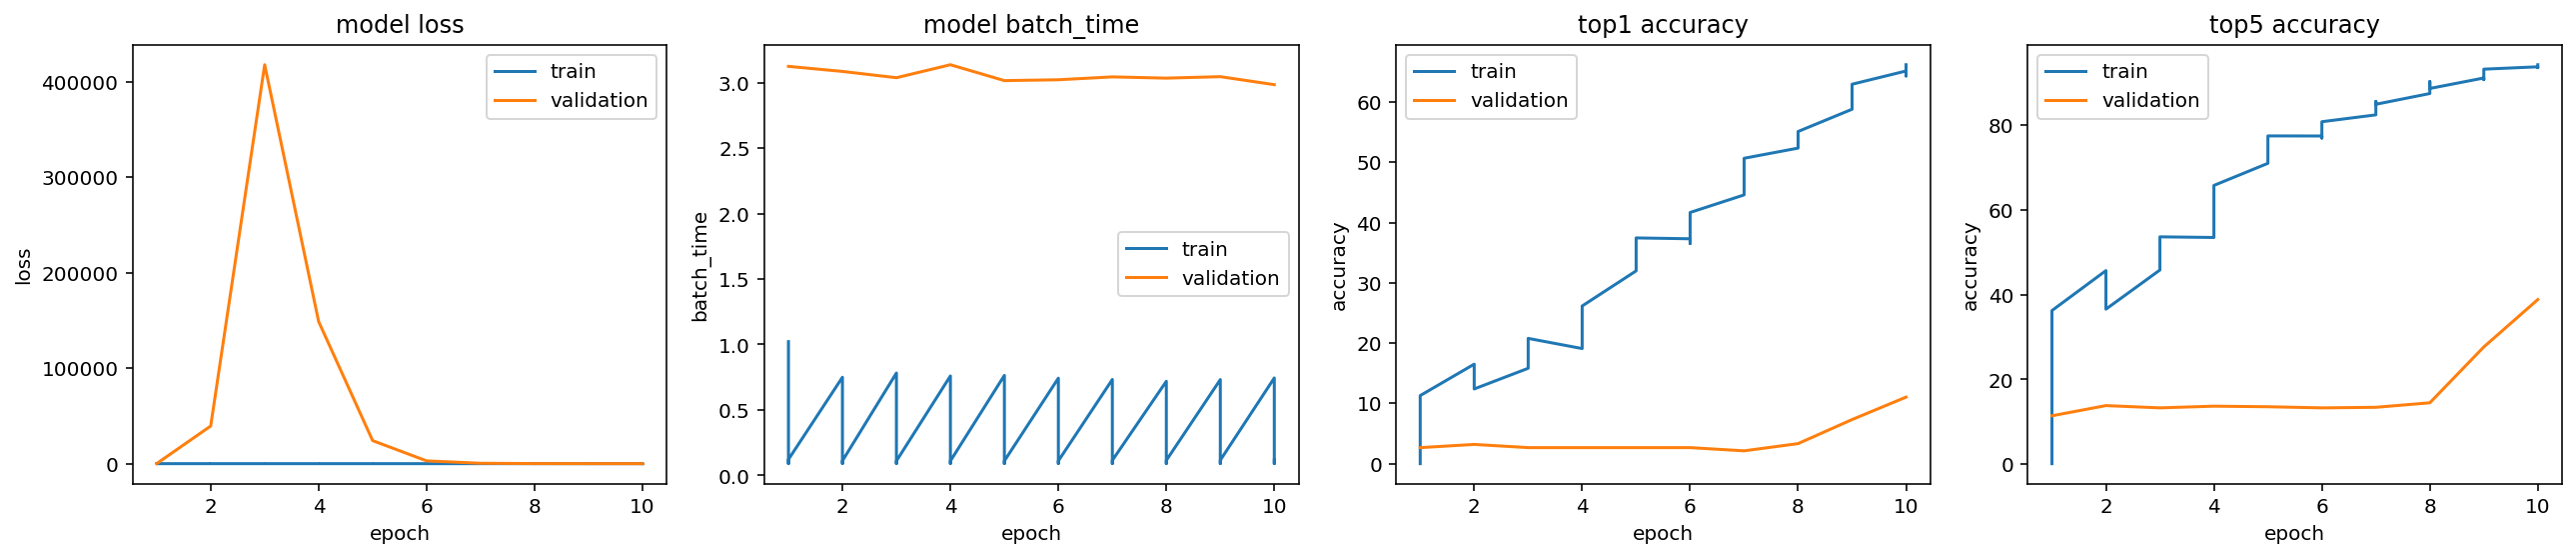

In [30]:
import matplotlib.pyplot as plt

def plot_training_curves(history): 
    
    fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharex=True)
    
    ax = axes[0]
    ax.plot(history['epoch'], history['losses'], label='train')
    ax.plot(history['val_avg_epoch'], history['val_avg_losses'], label='validation')
    ax.set(
        title='model loss',
        ylabel='loss',
        xlabel='epoch')
    ax.legend()
    
    ax = axes[1]
    ax.plot(history['epoch'], history['batch_time'], label='train')
    ax.plot(history['val_avg_epoch'], history['val_avg_batch_time'], label='validation')
    ax.set(
        title='model batch_time',
        ylabel='batch_time',
        xlabel='epoch')
    ax.legend()
    
    
    ax = axes[2]
    ax.plot(history['epoch'], history['top1'], label='train')
    ax.plot(history['val_avg_epoch'], history['val_avg_top1'], label='validation')
    ax.set(
        title='top1 accuracy',
        ylabel='accuracy',
        xlabel='epoch')
    ax.legend()
    
    ax = axes[3]
    ax.plot(history['epoch'], history['top5'], label='train')
    ax.plot(history['val_avg_epoch'], history['val_avg_top5'], label='validation')
    ax.set(
        title='top5 accuracy',
        ylabel='accuracy',
        xlabel='epoch')
    ax.legend()
    fig.tight_layout()
    
plot_training_curves(model_history)

In [31]:
%store hyperparameters model_dir output_dir artifacts_dir

Stored 'hyperparameters' (dict)
Stored 'model_dir' (str)
Stored 'output_dir' (str)
Stored 'artifacts_dir' (str)


<p></p>
<p>Amazon SageMaker에서 모든 학습을 완료하였습니다. </p>